In [35]:
import os
print(os.getcwd())

import sys
sys.path.append('../Utilities/src')
from DA_tools.DA_colors2 import *


import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import pandas as pd


import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


from numpy.random import normal,standard_t
from scipy.special import expit,logit
from svgpathtools import Path, Line, CubicBezier, wsvg



/Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks


0.0

In [37]:
def convert_to_tikz_points(tuple):
    return '\\fill[color=dark] ({0:1.2f}, {1:1.2f}) circle (7pt);\n\\fill[color=light] ({0:1.2f}, {1:1.2f}) circle (5pt);\n'.format(tuple[0],tuple[1])

In [38]:
def curve_to_points(NUM_SAMPLES,sigmas=[0,0],*segments):
    bezier_path = Path(*segments)
    myPath = []
    for i in range(NUM_SAMPLES):
        myPath.append(bezier_path.point(i/(float(NUM_SAMPLES)-1)))
    q1 = np.asarray(myPath).real+normal(size=NUM_SAMPLES,scale=sigmas[0])
    q2 = np.asarray(myPath).imag+normal(size=NUM_SAMPLES,scale=sigmas[0])
    return q1,q2

In [39]:
def write_points_to_tikz(q1,q2,filename,path='../tikz/',arrows=False):
    with open(path+filename, 'w') as f:
        if arrows:
            old_tuple=()
        for tuple in zip(q1,q2):
            f.write(convert_to_tikz_points(tuple))
            if arrows:
                if len(old_tuple)>0:
                    arrow = '\draw[draw=light,->,shorten >=1mm,shorten <=1mm] ({0:1.2f},{1:1.2f})--({2:1.2f},{3:1.2f});\n'.format(old_tuple[0],old_tuple[1],tuple[0],tuple[1])
                    f.write(arrow)
                old_tuple=tuple
    


In [164]:
def mc_stats(mcmc_samples, warmup_iters=0, variable_names=[],n_chains=1):
    col_names = ['mean','standard deviation', 'mcmc_se', 'ESS', 'split_Rhat']
    df = pd.DataFrame(columns=col_names)
    m,n = mcmc_samples.shape
    if len(variable_names)==0:
        variable_names = ['var_'+str(x+1) for x in range(n-1)]
        variable_names.append('acceptance probability')
    if len(variable_names)==n-1:
        variable_names.append('acceptance probability')
    for i in range(n):
        data=np.zeros(5)
        var_i = mcmc_samples[warmup_iters+1:,i]
        data[0] = np.mean(var_i)
        data[1] = np.std(var_i)
        data[2] = az.mcse(var_i)
        data[4] = az.rhat(np.array(np.split(var_i,2*n_chains)))
        data[3] = np.round(az.ess(var_i))
        df.loc[variable_names[i]] = data
    return df






# Probabilistic computation - Markov Chain Monte Carlo



### Markov Chains

_Markov transition distribution_ is a conditional probability density function
within a given parameterization of the parameter space Q:

$$
\begin{alignat*}{6}
T :\; &Q \times Q& &\rightarrow& \; &\mathbb{R}^{+}&
\\
&(q, q')& &\mapsto& &T(q' \mid q)&.
\end{alignat*}
$$



## Example - 2 dimensional space 
$$
\begin{align*}
T(q_{1} \mid q_{0} )
&=
T(q^{1}_{1}, q^{2}_{1} \mid q^{1}_{0}, q^{2}_{0} )
\\
&=
T(q^{1}_{1} \mid q^{1}_{0}) \cdot
T(q^{2}_{1} \mid q^{2}_{0}).
\\
&=
\text{Normal}(q^{1}_{1} \mid q^{1}_{0}, \sigma) \cdot
\text{Normal}(q^{2}_{1} \mid q^{2}_{0}, \sigma).
\end{align*}
$$

In [40]:
q0 = np.array([0,0])
n_possible = 50
sigma = 1
np.random.seed(28052021)
possible_qs = normal(loc=q0,scale=np.array([sigma, sigma]),size=(n_possible,2))
q1 = possible_qs[0,:]
possible_qs_1 = normal(loc=q1,scale=np.array([sigma, sigma]),size=(n_possible,2))
q2 = possible_qs_1[1,:]


arrow_props = {'arrowstyle':'->','color':LIGHT}

def plotarrow(ax,q1,q2):
    ax.annotate(text='',xytext=q1,xy=q2,arrowprops=arrow_props)
    return ax


## Possible transitions from initial point

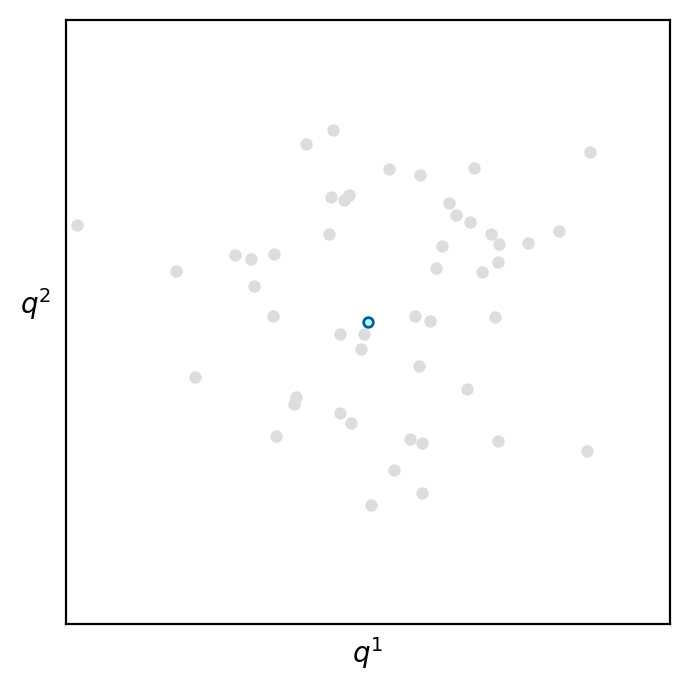

In [41]:
fig_markov_potential,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs[:,0],possible_qs[:,1],c=LIGHT_GREY,s=12)
ax.scatter(q0[0],q0[1],ec=DARK,fc=LIGHT,s=12)

ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$',rotation=0)
ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.set_label_coords(-.05, 0.5)
ax.set_aspect('equal')
fig_markov_potential.savefig('../markdown/img/markov_potential_initial_transition.png')


## Realized transition from initial point

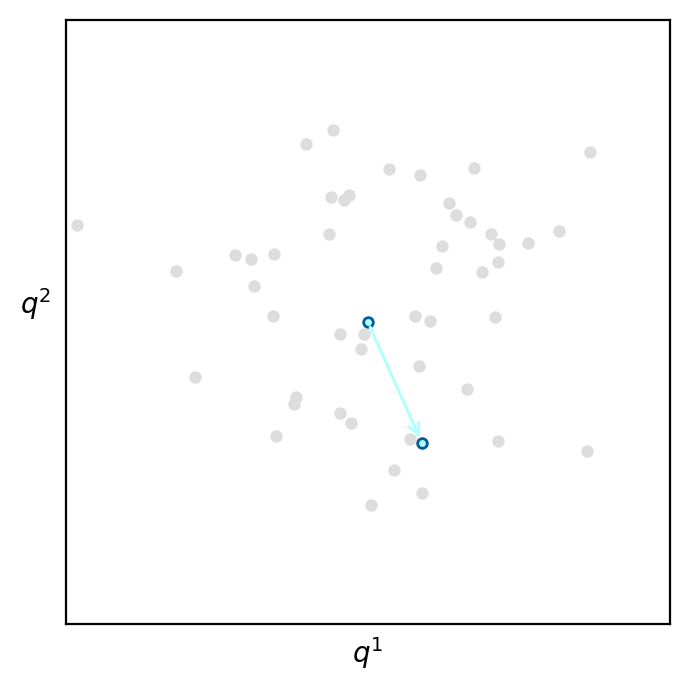

In [42]:
fig_markov_realized,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs[:,0],possible_qs[:,1],c=LIGHT_GREY,s=12)
ax.scatter(q0[0],q0[1],ec=DARK,fc=LIGHT,s=12)
ax.scatter(q1[0],q1[1],ec=DARK,fc=LIGHT,s=12)
plotarrow(ax,q0,q1)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$',rotation=0)
ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.set_label_coords(-.05, 0.5)
ax.set_aspect('equal')
plotarrow(ax,q0,q1)

fig_markov_potential.savefig('../markdown/img/markov_realized_initial_transition.png')


## Possible transitions from first transition

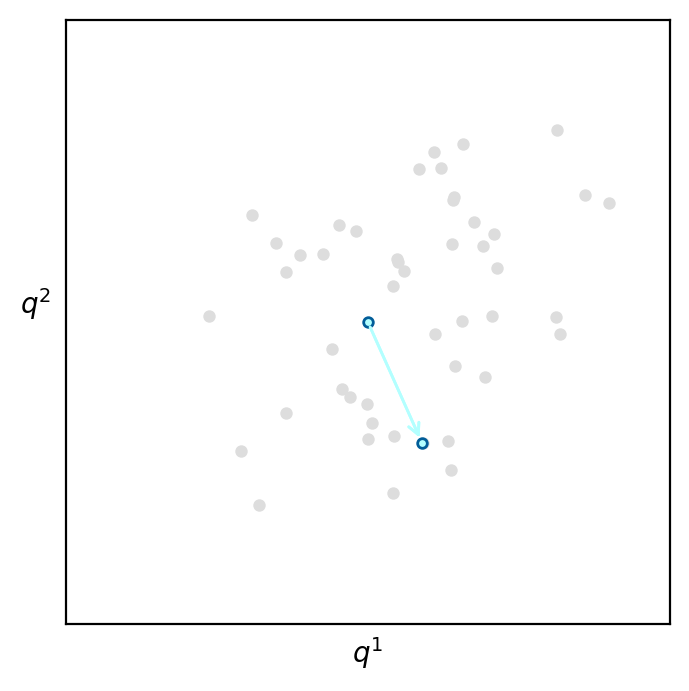

In [43]:
fig_markov_possible_second,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs_1[:,0],possible_qs[:,1],c=LIGHT_GREY,s=12)
ax.scatter(q0[0],q0[1],ec=DARK,fc=LIGHT,s=12)
ax.scatter(q1[0],q1[1],ec=DARK,fc=LIGHT,s=12)
plotarrow(ax,q0,q1)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$',rotation=0)
ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.set_label_coords(-.05, 0.5)
ax.set_aspect('equal')
plotarrow(ax,q0,q1)

fig_markov_possible_second.savefig('../markdown/img/markov_possible_second_transition.png')

## Realized transition from first transition

In [44]:
fig_markov_realized_second,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs_1[:,0],possible_qs[:,1],c=LIGHT_GREY,s=12)
ax.scatter(q0[0],q0[1],ec=DARK,fc=LIGHT,s=12)
ax.scatter(q1[0],q1[1],ec=DARK,fc=LIGHT,s=12)
ax.scatter(q2[0],q2[1],ec=DARK,fc=LIGHT,s=12)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$',rotation=0)
ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.set_label_coords(-.05, 0.5)
ax.set_aspect('equal')
plotarrow(ax,q0,q1)
plotarrow(ax,q1,q2)

fig_markov_possible_second.savefig('../markdown/img/markov_realized_second_transition.png')

## Markov Chain

_Iterating_ Markov transitions,
$$
\begin{align*}
\tilde{q}_{1} &\sim T(q_{1} \mid q_{0})
\\
\tilde{q}_{2} &\sim T(q_{2} \mid \tilde{q}_{1})
\\
\tilde{q}_{3} &\sim T(q_{3} \mid \tilde{q}_{2})
\\
\ldots
\\
\tilde{q}_{N} &\sim T(q_{N} \mid \tilde{q}_{N - 1}),
\end{align*}
$$
generates a sequence of points in the ambient space that we call a
_Markov chain_.


## Main point - stationary distribution

A probability distribution that is
preserved under Markov transitions,
$$
\pi(q) = \int \, \pi(q') \, T(q \mid q')  \mathrm{d} q'
$$
is known as the _stationary_ or _invariant_ distribution of the Markov
transition distribution.

Well-behaved Markov transition distributions admit a
unique stationary distribution, and it is within the ***stationary typical set***
that the Markov chains are most likely to wonder.

In [45]:

bezier_curve0 = CubicBezier(start=(-15+-7j), control1=(-15+-8j), control2=(-10+1j), end=(-10+-2j))
bezier_curve1 = CubicBezier(start=(-10+-2j), control1=(-10+5j), control2=(-9+10j), end=(-4+10j))
bezier_curve2 = CubicBezier(start=(-4+10j), control1=(1+10j), control2=(10+3j), end=(10-3j))
bezier_curve3 = CubicBezier(start=(10-3j), control1=(10-9j), control2=(3-2j), end=(-1+-2j))
bezier_curve4 = CubicBezier(start=(-1+-2j), control1=(-6-2j), control2=(-10-9j), end=(-10-2j))


bezier_path_mcmc = Path(bezier_curve0,bezier_curve1)

NUM_SAMPLES = 15


q1,q2 = curve_to_points(NUM_SAMPLES,[0.3,0.3], bezier_curve0,bezier_curve1)



In [46]:
write_points_to_tikz(q1,q2,'ts_mcmc_samples_1.tex',arrows=True)

## Markov chain converges towards typical set of distribution

In [47]:
input_file = 'typical_set_mcmc_samples1.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

In [48]:
NUM_SAMPLES = 55

q1,q2 = curve_to_points(NUM_SAMPLES,[0.3,0.3], bezier_curve0,bezier_curve1,bezier_curve2,bezier_curve3,bezier_curve4)
write_points_to_tikz(q1[:53],q2[:53],'ts_mcmc_samples_2.tex')



## After reaching it it explores it

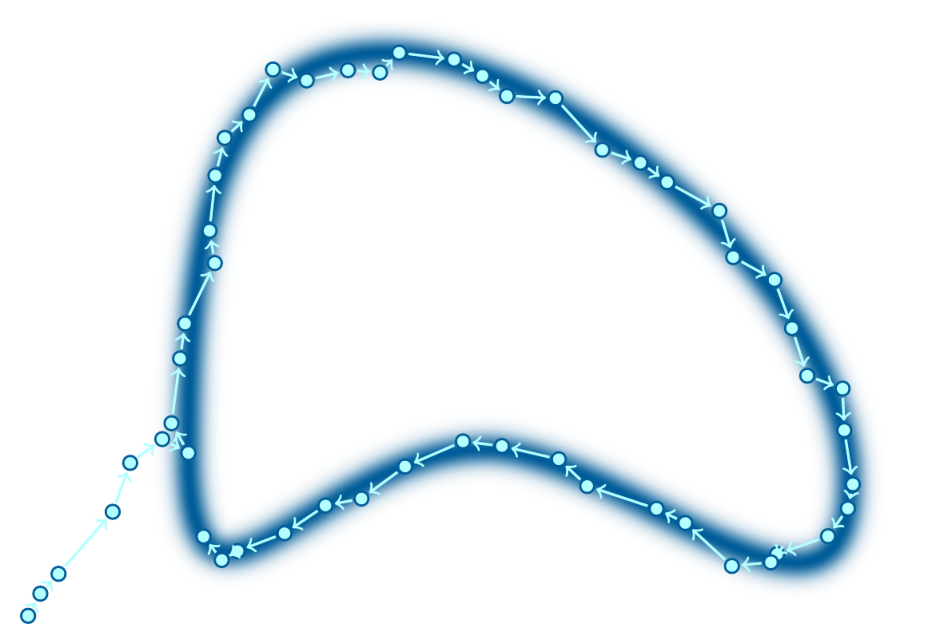

In [49]:
input_file = 'typical_set_mcmc_samples2.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

## MCMC estimators

MCMC estimators are analogous to MC ones

$$
\hat{f}^{MCMC}_N = \frac{1}{N} \sum_{n=1}^{N}f(q_n)
$$

As long as Markov chains are _irreducible_ and _aperiodic_ they are _recurrent_, which ensures asymptotical consistency:

$$
\lim_{N\rightarrow\infty}\hat{f}^{MCMC}_N = \mathbb{E}_\pi[f]
$$

## What about finite sample behavior?

The ideal case

## Initial convergence


In [50]:
NUM_SAMPLES = 7
q1,q2 = curve_to_points(NUM_SAMPLES,[0.3,0.3], bezier_curve0)
write_points_to_tikz(q1,q2,'ts_mcmc_samples_no_arrows_1.tex')

In [51]:
input_file = 'typical_set_mcmc_samples_progress_1.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')

fig, ax = plt.subplots(1,2,figsize=(7,4),tight_layout = True)
ax[0].imshow(pic_grid[0])
ax[0].axis('off')
x=np.linspace(0,3,400)
soft_max = lambda x: 0.5*(x+np.sqrt((1)**2+x**2))
fun = lambda x:soft_max((1-(x)**4))
ax[1].plot(x[:100],fun(x[:100]),c=DARK)
ax[1].set_xlim(0,3)
ax[1].set_ylim(0,1.3)
ax[1].set_ylabel(r'$|\mathbb{E}\ [f]-\hat{f}|$')
ax[1].set_xlabel('Iteration')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()
fig.savefig('../markdown/img/mcmc_ideal_1.png')


## Initial mixing

In [52]:
NUM_SAMPLES = 25
q1,q2 = curve_to_points(NUM_SAMPLES,[0.3,0.3], bezier_curve1, bezier_curve2, bezier_curve3, bezier_curve4)
write_points_to_tikz(q1,q2,'ts_mcmc_samples_no_arrows_2.tex')

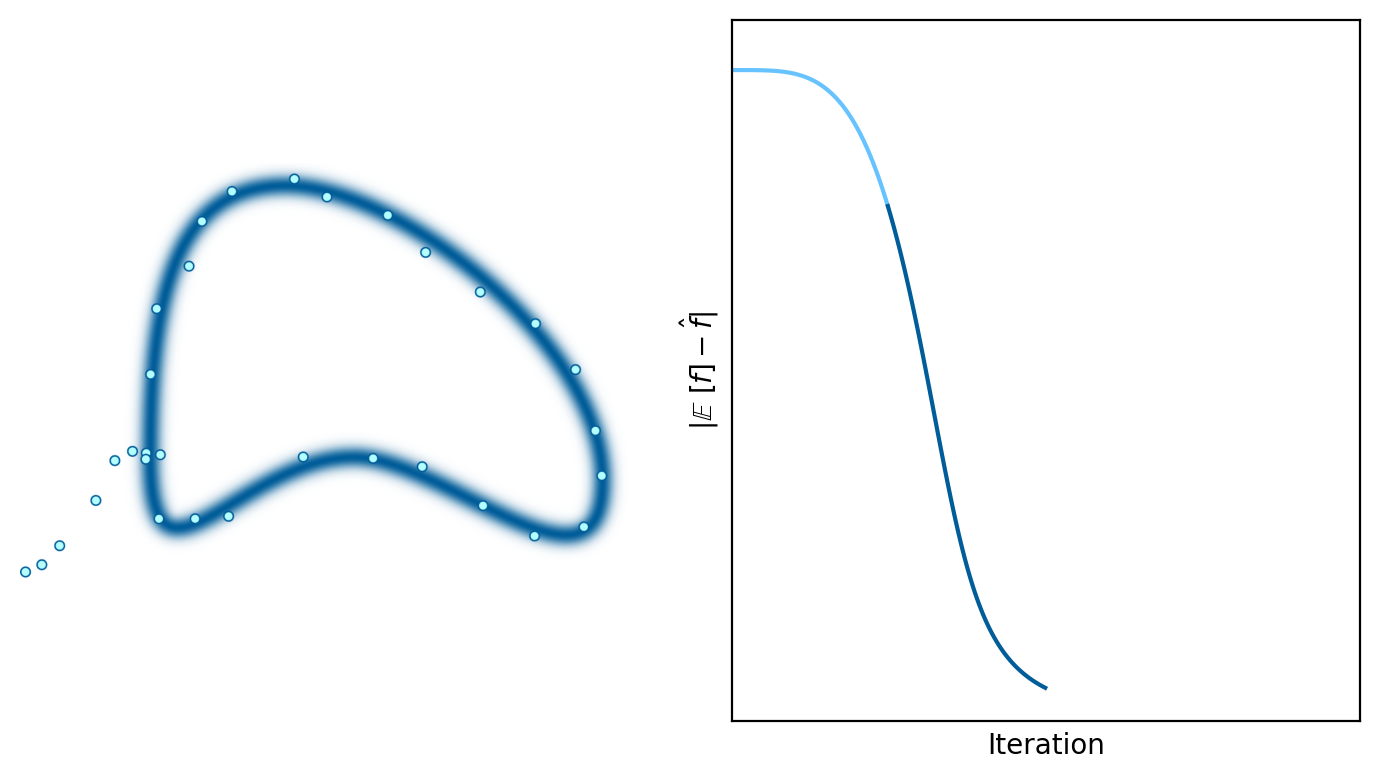

In [53]:
input_file = 'typical_set_mcmc_samples_progress_2.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')


fig, ax = plt.subplots(1,2,figsize=(7,4),tight_layout = True)
ax[0].imshow(pic_grid[0])
ax[0].axis('off')
ax[1].plot(x[:100],fun(x[:100]),c=MID)
ax[1].plot(x[99:200],fun(x[99:200]),c=DARK)
ax[1].set_xlim(0,3)
ax[1].set_ylim(0,1.3)
ax[1].set_ylabel(r'$|\mathbb{E}\ [f]-\hat{f}|$')
ax[1].set_xlabel('Iteration')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()
fig.savefig('../markdown/img/mcmc_ideal_2.png')

## Refining


In [54]:
NUM_SAMPLES = 100
q1,q2 = curve_to_points(NUM_SAMPLES,[0.3,0.3], bezier_curve1, bezier_curve2, bezier_curve3, bezier_curve4)
write_points_to_tikz(q1,q2,'ts_mcmc_samples_no_arrows_3.tex')

In [55]:
input_file = 'typical_set_mcmc_samples_progress_3.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')


fig, ax = plt.subplots(1,2,figsize=(7,4),tight_layout = True)
ax[0].imshow(pic_grid[0])
ax[0].axis('off')
ax[1].plot(x[:200],fun(x[:200]),c=MID)
ax[1].plot(x[199:],fun(x[199:]),c=DARK)
ax[1].set_xlim(0,3)
ax[1].set_ylim(0,1.3)
ax[1].set_ylabel(r'$|\mathbb{E}\ [f]-\hat{f}|$')
ax[1].set_xlabel('Iteration')
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()
fig.savefig('../markdown/img/mcmc_ideal_3.png')

## Complications with geometry

Typical set can be very irregular

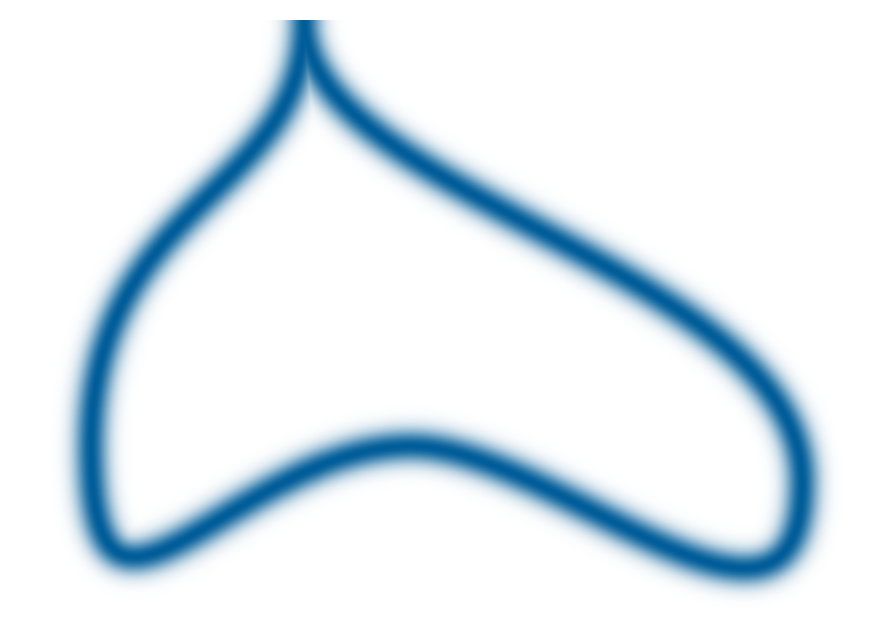

In [154]:
input_file = 'typical_set_funnel.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

## Initial exploration can be ok

In [56]:

bezier_funnel_left_1 = CubicBezier(start=(-10+-2j), control1=(-10+5j), control2=(-4+5j), end=(-4+10j))
bezier_path = Path(bezier_funnel_left_1)
NUM_SAMPLES = 25


q1,q2 = curve_to_points(NUM_SAMPLES,[0.1,0.1],bezier_funnel_left_1)
write_points_to_tikz(q1,q2,'funnel_samples_1.tex')

In [57]:
input_file = 'typical_set_funnel_samples1.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

In [58]:

q1,q2 = curve_to_points(250,[0.3,0.3],bezier_funnel_left_1)
x=[*range(len(q1))]

fig_trace_funnel_1,ax = plt.subplots(2,1,figsize=(7,4),sharex=True,tight_layout=True)
ax[0].scatter(x=x,y=q1,ec=DARK,fc=LIGHT,s=12)
ax[1].scatter(x=x,y=q2,ec=DARK,fc=LIGHT,s=12)

ax[0].set_ylabel('$q^1$',rotation=0)
ax[1].set_ylabel('$q^2$',rotation=0)
# ax.set_xlim((-3,3))
# ax.set_ylim((-3,3))
ax[0].set_yticks([])
ax[1].set_yticks([])

ax[1].set_xticks([])
ax[0].yaxis.set_label_coords(-.03, 0.5)
ax[1].yaxis.set_label_coords(-.03, 0.5)
ax[1].set_xlabel('Iterations')
# ax.set_aspect('equal')
fig_trace_funnel_1.savefig('../markdown/img/markov_funnel_trace_1.png')

In [59]:
q1_1 = normal(size=40,loc=q1[-1],scale=0.1)
q2_1 = normal(size=40,loc=q2[-1],scale=0.1)
write_points_to_tikz(q1_1,q2_1,'funnel_samples_2')

## Approaching difficult shapes complicates transitions


In [60]:
input_file = 'typical_set_funnel_samples2.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

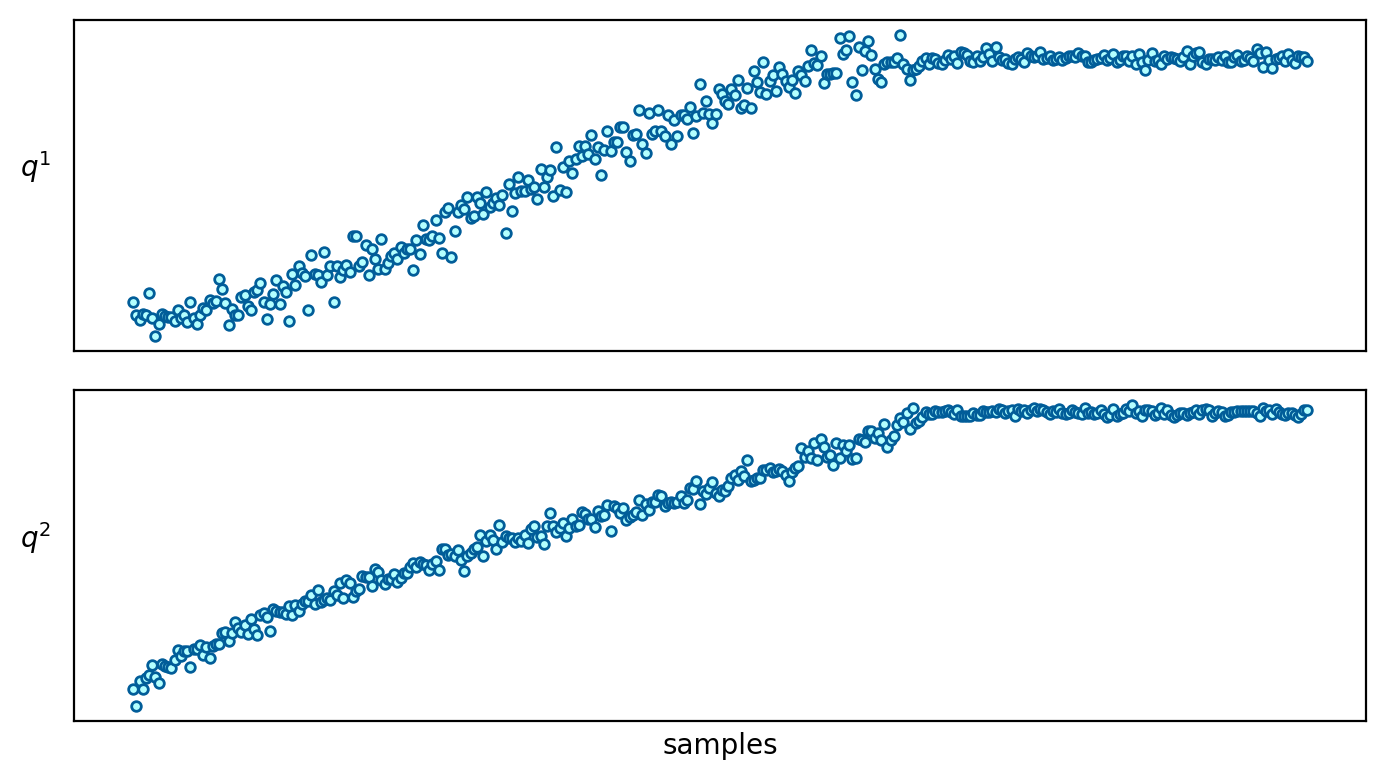

In [61]:
q1_1 = normal(size=120,loc=q1[-1],scale=0.1)
q2_1 = normal(size=120,loc=q2[-1],scale=0.1)
q1c = np.append(q1,q1_1)
q2c = np.append(q2,q2_1)

x=[*range(len(q1c))]

fig_trace_funnel_2,ax = plt.subplots(2,1,figsize=(7,4),sharex=True,tight_layout=True)
ax[0].scatter(x=x,y=q1c,ec=DARK,fc=LIGHT,s=12)
ax[1].scatter(x=x,y=q2c,ec=DARK,fc=LIGHT,s=12)

ax[0].set_ylabel('$q^1$',rotation=0)
ax[1].set_ylabel('$q^2$',rotation=0)
# ax.set_xlim((-3,3))
# ax.set_ylim((-3,3))
ax[0].set_yticks([])
ax[1].set_yticks([])

ax[1].set_xticks([])
ax[0].yaxis.set_label_coords(-.03, 0.5)
ax[1].yaxis.set_label_coords(-.03, 0.5)
ax[1].set_xlabel('samples')
# ax.set_aspect('equal')
fig_trace_funnel_1.savefig('../markdown/img/markov_funnel_trace_2.png')

## Even escaping irregularities can lead to biases

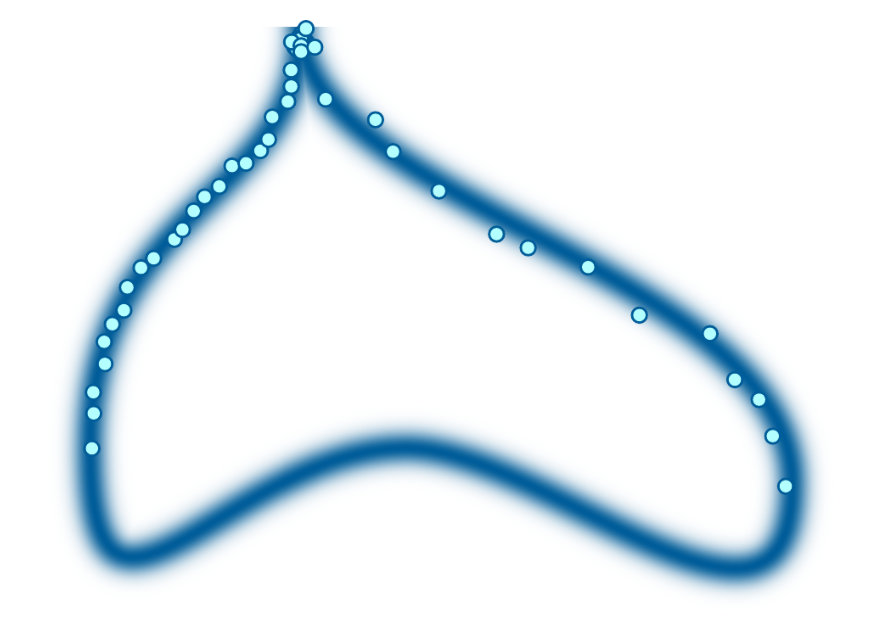

In [62]:
bezier_funnel_left_2 = CubicBezier(start=(-4+10j), control1=(-4+5j), control2=(10+3j), end=(10-3j))
NUM_SAMPLES = 15

q1,q2 = curve_to_points(NUM_SAMPLES,[0.3,0.3],bezier_funnel_left_2)
write_points_to_tikz(q1,q2,'funnel_samples_3.tex')

input_file = 'typical_set_funnel_samples3.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

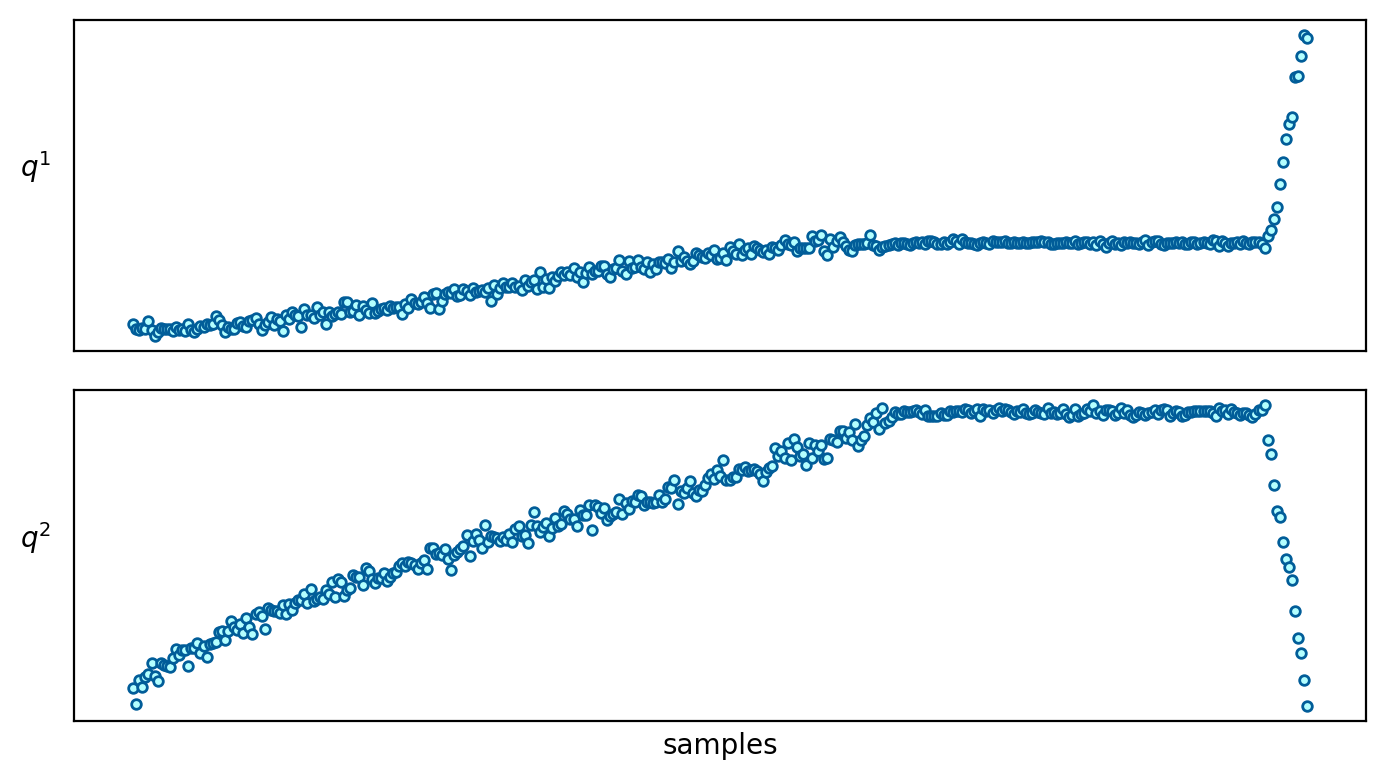

In [63]:
q1_2,q2_2 = curve_to_points(NUM_SAMPLES,[0.3,0.3],bezier_funnel_left_2)

q1c2 = np.append(q1c,q1_2)
q2c2 = np.append(q2c,q2_2)

x=[*range(len(q1c2))]

fig_trace_funnel_2,ax = plt.subplots(2,1,figsize=(7,4),sharex=True,tight_layout=True)
ax[0].scatter(x=x,y=q1c2,ec=DARK,fc=LIGHT,s=12)
ax[1].scatter(x=x,y=q2c2,ec=DARK,fc=LIGHT,s=12)

ax[0].set_ylabel('$q^1$',rotation=0)
ax[1].set_ylabel('$q^2$',rotation=0)
# ax.set_xlim((-3,3))
# ax.set_ylim((-3,3))
ax[0].set_yticks([])
ax[1].set_yticks([])

ax[1].set_xticks([])
ax[0].yaxis.set_label_coords(-.03, 0.5)
ax[1].yaxis.set_label_coords(-.03, 0.5)
ax[1].set_xlabel('samples')
# ax.set_aspect('equal')
fig_trace_funnel_1.savefig('../markdown/img/markov_funnel_trace_2.png')

## Markov Chain Monte Carlo Central Limit Theorem

For sufficiently long Markov chains estimator behavior is approximately Gaussian
$$
\hat{f}^{\text{MCMC}}_{N} \sim \text{normal}( \mathbb{E} [f], \text{MCMC-SE}[f] ),
$$
where the _Markov chain Monte Carlo standard error_ is defined as
$$
\begin{align*}
\text{MCMC-SE}[f]
&= \sqrt{ \frac{ \text{Var} [f] }{ \text{ESS}[f] } }
\end{align*}
$$
$\text{ESS}[f]$ is called the
_effective sample size_.

## Effective sample size

This is the measure of how the Markov chain is autocorrelated with itself. It is given by
$$
\text{ESS}[f] = \frac{N}{1 + 2 \, \sum_{l = 1}^{\infty} \rho_{l}[f]}.
$$

where $\rho_{l}$ are given by


$$
\rho_{l}[f] =
\frac{ \mathbb{E}[ ( f (q_{n + l}) - \mu_{f} ) ( f(q_{n}) - \mu_{f}) ] }
{ \mathrm{Var}_{\pi}[f] },
$$

## Practical ESS Estimator

Finite sums are good approximators, so

$$
\widehat{\mathrm{ESS}}[f] = \frac{N}{1 + 2 \sum_{l = 1}^{L} \hat{\rho}_{l}[f] }.
$$

with 

$$
\hat{\rho}_{l}[f]
=
\frac{ \frac{1}{N} \sum_{n = 0}^{N - l}
( f (q_{n + l}) - \hat{\mu}_{f} ) ( f(q_{n}) -\hat{\mu}_{f}) }
{ \widehat{\mathrm{Var}}[f] },
$$

## ESS interpretation

For independent samples all autocorrelations will vanish and
$$
\sum_{l = 1}^{\infty} \rho_{l}[f] = 0.
$$
In this case $\text{ESS}[f] = N$ and the Markov chain Monte Carlo standard error
reduces to the Monte Carlo standard error.

Positive autocorrelations,
$$
\sum_{l = 1}^{\infty} \rho_{l}[f] > 0,
$$
suppress the effective sample size which in turn increases the Markov chain
Monte Carlo standard error.

Negative autocorrelations,
$$
\sum_{l = 1}^{\infty} \rho_{l}[f] < 0,
$$
actually _enhance_ the effective sample size relative to the total number of
iterations which then _decreases_ the Markov chain Monte Carlo standard error
below the Monte Carlo standard error

## The Estimated Central Limit Theorem

$$
\hat{f} \sim \text{normal}( \mathbb{E} [f], \widehat{\text{MCMC-SE}}[f] ),
$$
where
$$
\widehat{\text{MCMC-SE}}[f] =
\sqrt{ \frac{ \widehat{ \text{Var}} [f] }{ \widehat{\text{ESS}} [ f ] } }
$$

## Warmup

- Theoretically - after initialization
- Adaptively - use the information from chain to detect
- Heuristically - drop fixed number of iterations

## Metropolis-Hastings algorithm - generating MC with desired stationary distribution $\pi(q)$

1. Let $K(q \mid q')$ be a _proposal distribution_ - we wil generate possible transition from it
2. _Metropolis-Hastings acceptance probability_ between an initial point, $q$,
and a proposal, $q'$:
$$
a(q', q) = \min \left(1,
\frac{ K(q \mid q') \, \pi(q') }{ K(q' \mid q) \, \pi(q) } \right).
$$
3. We can then define a Metropolis transition as a mixture of jumping to the proposal with probability $a(q', q)$ and staying at the initial point with probability $1 - a(q', q)$.


Often proposal distribution is normal - for example _random walk Metropolis_

$$
K(q' \mid q, \Sigma) = \text{normal}(q' \mid q, \Sigma).
$$

In [213]:
def MH_random_walk(target,dimension, n_transitions=5000,sigma=2):
    sigma = sigma
    D = dimension
    mcmc_samples = np.zeros((n_transitions+1,D+1))
    mcmc_samples[0, 0:D] = np.random.normal(0, 5,D) #starting point
    mcmc_samples[0, D ] = 1 #initial acceptance
    for n in range(n_transitions):
        q0 = mcmc_samples[n, 0:D] # Initial point
        qp = np.random.normal(q0, sigma,D)  # Proposal

        # Compute acceptance probability
        accept_prob = np.min([1., np.exp(target(qp) - target(q0))])
        mcmc_samples[n, D] = accept_prob #store accept prob

        # Apply Metropolis correction
        u = np.random.uniform()
        if accept_prob > u:
            mcmc_samples[n + 1, 0:D] = qp
        else:
            mcmc_samples[n + 1, 0:D] = q0
    return mcmc_samples

<img src="img/traces/gauss_trace.png" alt="drawing" width="800"/>


## Normal example

$$
q\sim\mathrm{Normal}\left(\begin{bmatrix}1\\-1\end{bmatrix},1\right)
$$

In [64]:
target_lpdf = lambda q:   - 0.5 * ( (q[0] - 1)**2 + (q[1] + 1)**2 ) - 0.5 * 2 * np.log(6.283185307179586)


In [159]:
q_1=np.linspace(-2,4,600)
q_2=np.linspace(-4,2,600)
Q1,Q2 = np.meshgrid(q_1,q_2)
Z = np.zeros(Q1.shape)
for i in range(600):
    for j in range(600):
        Z[i,j]=np.exp(target_lpdf((Q1[i,j],Q2[i,j])))


Text(0, 0.5, '$q^2$')

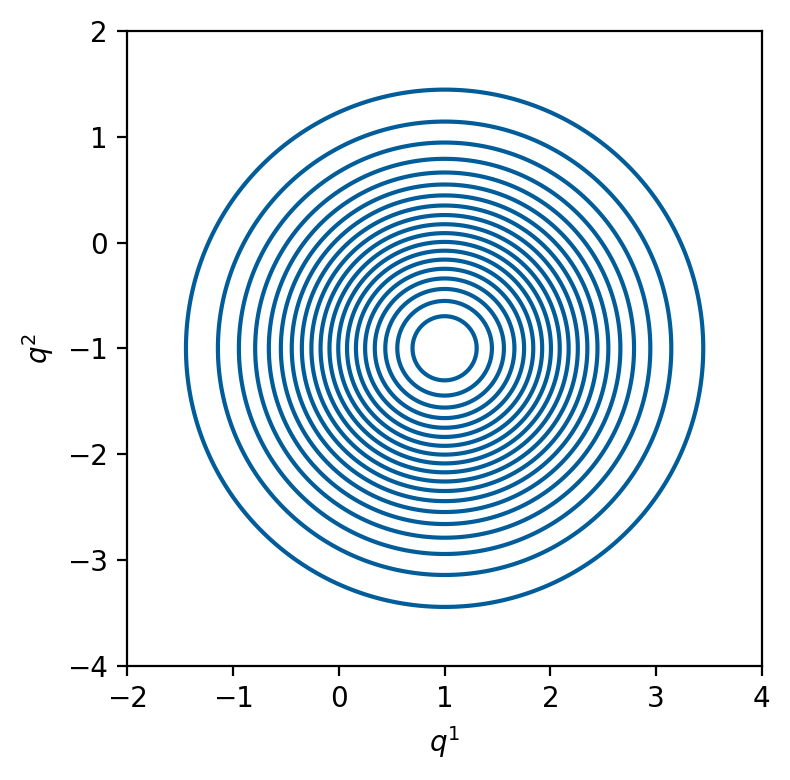

In [160]:
fig,ax = plt.subplots(1,1,figsize=(7,4),tight_layout=True)
ax.contour(Q1,Q2,Z,levels=25,colors=DARK)
ax.set_aspect('equal')
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$')

In [155]:
n_transitions = 5000
D = 2 
sigma = 1.4

np.random.seed(25032021)
mcmc_samples = MH_random_walk(target_lpdf,D, n_transitions=5000,sigma=1.4)


## Looking for stationarity


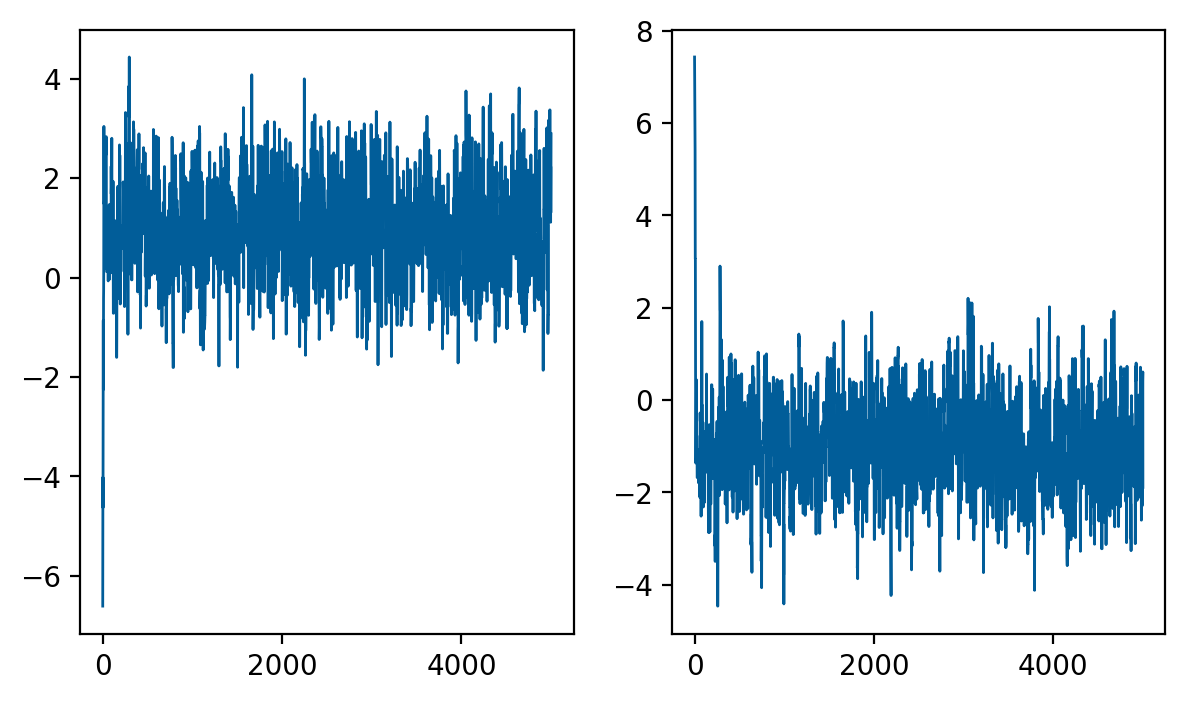

In [157]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))
ax1.plot(mcmc_samples[:,0],color=DARK,linewidth=1)
ax2.plot(mcmc_samples[:,1],color=DARK,linewidth=1)
plt.show()



## Multiple chains analysis


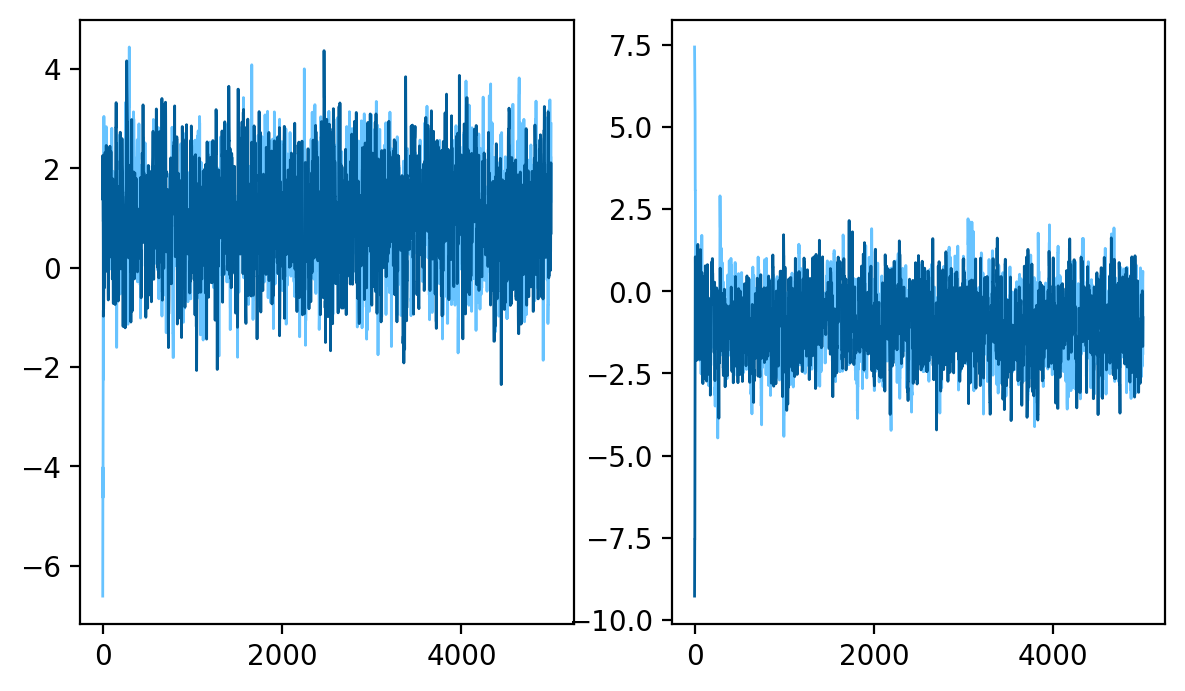

In [163]:
np.random.seed(17)
mcmc_samples2 = MH_random_walk(target_lpdf,D, n_transitions=5000,sigma=1.4)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))
ax1.plot(mcmc_samples[:,0],color=MID,linewidth=1)
ax1.plot(mcmc_samples2[:,0],color=DARK,linewidth=1)
ax2.plot(mcmc_samples[:,1],color=MID,linewidth=1)
ax2.plot(mcmc_samples2[:,1],color=DARK,linewidth=1)
plt.show()

## Multichain diagnostics 

***Within chain variance*** $W[f]$ the empirical average of the square of the Markov chain Monte Carlo
standard errors,
$$
\hat{W}[f] = \frac{1}{C} \sum_{c = 1}^{C} (\text{MCMC-SE}_{c}[f])^{2}
$$

***Between chain variance***, $B[f]$, the empirical variance of the
Markov chain Monte Carlo estimators themselves,
$$
\hat{B}[f] = \frac{N}{C - 1} \sum_{c = 1}^{C}
\left( \hat{f}^{\text{MCMC}}_{c, N} - \hat{\hat{f}} \right)^{2},
$$

## $\hat{R}$ - potential scale reduction factor

$$
\hat{R}[f] = \sqrt{ \frac{N - 1}{N}
+ \frac{1}{N} \frac{ \hat{B} [ f ] }{ \hat{W} [ f] } }.
$$
As the ensemble of Markov chains reach the same equilibrium $\hat{R}$ should
approach one. 





## Geweke statistic

Comparison of the Markov chain Monte Carlo estimators derived at the beginning and end of a single Markov chain

$$
G = \frac{
\hat{f}^{\text{MCMC}}_{B, N_{B}}
- \hat{f}^{\text{MCMC}}_{E, N_{E}} }
{ \sqrt{
(\text{MCMC-SE}_{B}[f])^{2} + (\text{MCMC-SE}_{E}[f])^{2}
} }.
$$

$\hat{f}^{\text{MCMC}}_{B, N_{B}}$ denotes the Markov chain Monte Carlo estimator of the function $f$ from the first $N_{B}$
points at the beginning of a Markov chain and 

$\hat{f}^{\text{MCMC}}_{E, N_{E}}$
denotes the estimator from the last $N_{E}$ points

## Split $\hat{R}$

**split potential scale reduction factor**, or split $\hat{R}[f]$, combines
the qualitative features of both diagnostics by generating an ensemble of Markov
chains and then splitting them in half before computing the $\hat{R}$ statistic.
In this way split $\hat{R}$ can capture inconsistencies both between the Markov
chains in the ensemble as well as within each Markov chain.

In [156]:

mc_stats(mcmc_samples,warmup_iters=100)

mean  standard deviation   mcmc_se     ESS  \
var_1                   0.960934            0.989313  0.037116   712.0   
var_2                  -0.987321            0.998737  0.038749   666.0   
acceptance probability  0.425887            0.394915  0.005454  5215.0   

                        split_Rhat  
var_1                     1.001642  
var_2                     1.000868  
acceptance probability    1.000153

In [165]:
mcmc_samples.shape

(5001, 3)

In [168]:
mcmc_2chain = np.append(mcmc_samples,mcmc_samples2[101:],axis=0)
mc_stats(mcmc_2chain,warmup_iters=100,n_chains=2)

mean  standard deviation   mcmc_se      ESS  \
var_1                   0.995453            0.998860  0.026257   1442.0   
var_2                  -0.996668            0.994062  0.027990   1261.0   
acceptance probability  0.425364            0.394603  0.003887  10186.0   

                        split_Rhat  
var_1                     1.001529  
var_2                     1.004160  
acceptance probability    0.999996

In [71]:
mc_series = pd.DataFrame(mcmc_samples[100:,:2],columns=['var_1','var_2'])
N=len(mc_series)
series_mcse = lambda series: az.mcse(series.values)
expan_mean_1 = mc_series.var_1.expanding().mean()
expan_std_1 = mc_series.var_1.expanding().apply(series_mcse)
expan_mean_2 = mc_series.var_2.expanding().mean()
expan_std_2 = mc_series.var_2.expanding().apply(series_mcse)



arviz - WARNING - Shape validation failed: input_shape: (1, 1), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 2), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 3), minimum_shape: (chains=1, draws=4)


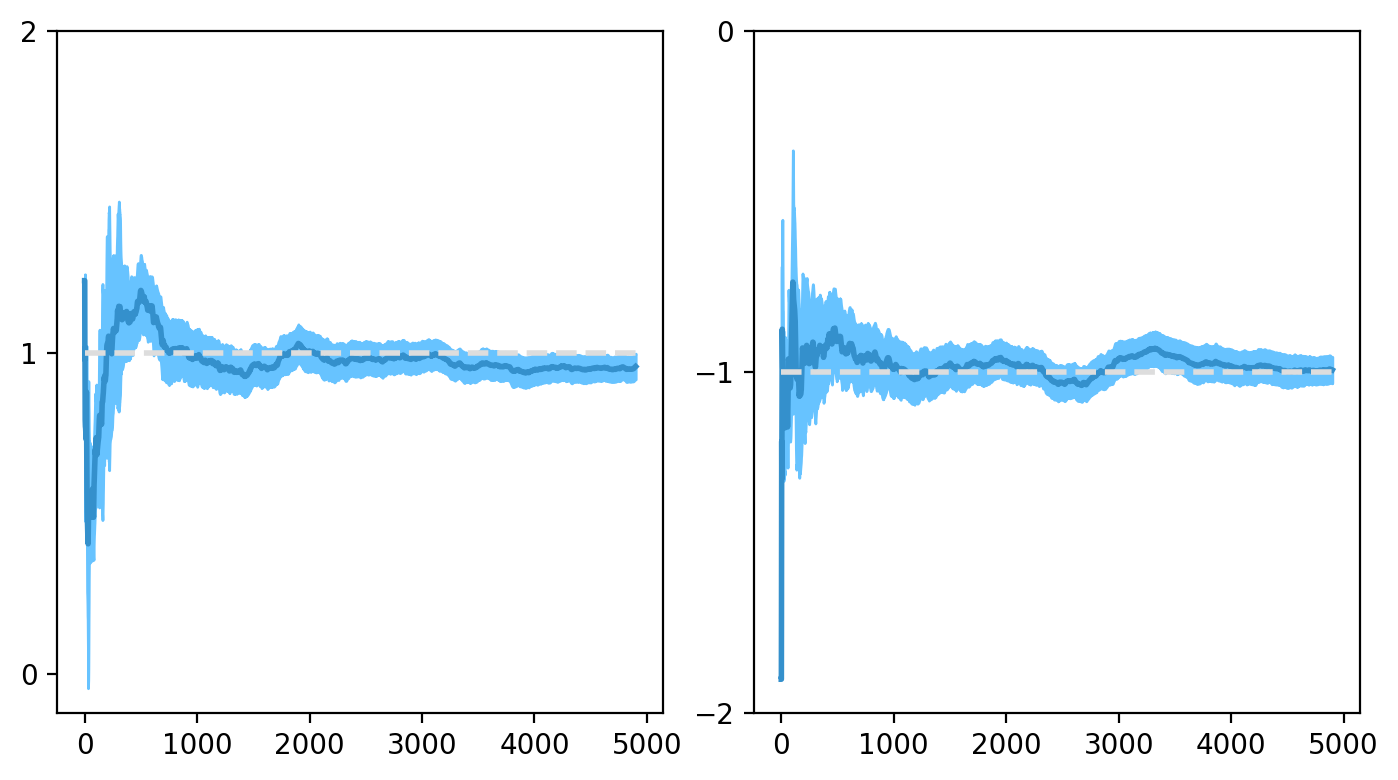

In [72]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(expan_mean_1,color=MID_HIGHLIGHT,linewidth=2)
ax1.plot([0,N],[1,1],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.fill_between([*range(N)],expan_mean_1-expan_std_1,expan_mean_1+expan_std_1,color=MID)

ax2.plot(expan_mean_2,color=MID_HIGHLIGHT,linewidth=2)
ax2.fill_between([*range(N)],expan_mean_2-expan_std_2,expan_mean_2+expan_std_2,color=MID)
ax2.plot([0,N],[-1,-1],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.set_yticks([0,1,2])
ax2.set_yticks([-2,-1,0])

plt.tight_layout()

In [73]:
res = np.array(np.split(mcmc_samples[101:,1],2))

In [74]:
az.rhat(res)

1.0031135258368309

In [75]:
np.mean(mcmc_samples[101:,0])

0.9566294769584612

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

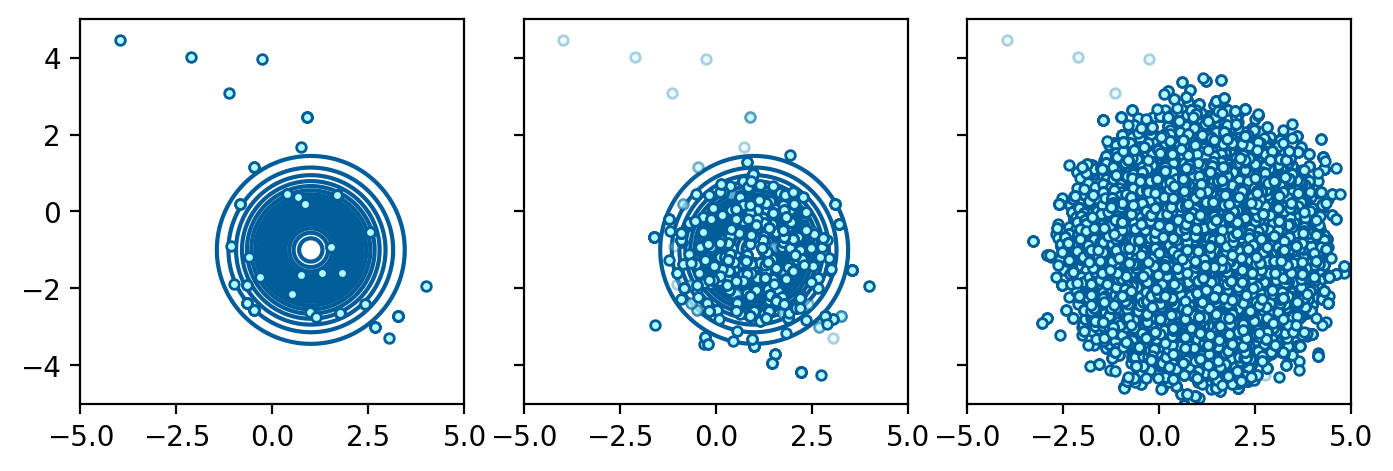

In [116]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = [7,4],tight_layout=True,sharey=True)
ax1.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax1.scatter(mcmc_samples[:101,0],mcmc_samples[:101,1],ec=DARK,fc=LIGHT,s=12,zorder=1)
ax1.set_ylim(-5,5)
ax1.set_xlim(-5,5)

ax1.set_aspect('equal')
ax2.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax2.scatter(mcmc_samples[:101,0],mcmc_samples[:101,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax2.scatter(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax2.set_ylim(-5,5)
ax2.set_xlim(-5,5)
ax2.set_aspect('equal')
ax3.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax3.scatter(mcmc_samples[:1001,0],mcmc_samples[:1001,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax3.scatter(mcmc_samples[1001:,0],mcmc_samples[1001:,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax3.set_ylim(-5,5)
ax3.set_xlim(-5,5)
ax3.set_aspect('equal')



<AxesSubplot:>

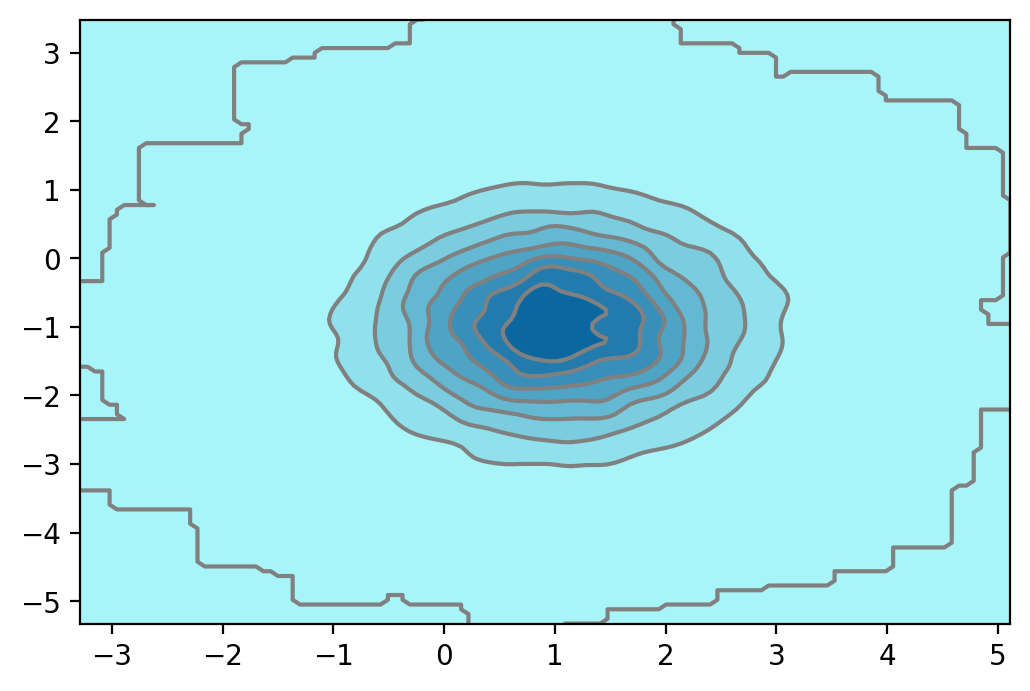

In [118]:
my_cmap= mpl.colors.LinearSegmentedColormap.from_list("",[LIGHT,DARK])

az.plot_dist(mcmc_samples[1001:,0],mcmc_samples[1001:,1],contourf_kwargs={'cmap':my_cmap})

## Complicated geometry example

We consider

$$
\begin{aligned}
\mu\sim{}&\mathrm{Normal}(0,1)\\
\log\tau\sim{}&\mathrm{Normal}(0,5)\\
\theta_i\sim{}&\mathrm{Normal}(\mu,\tau)\\
i={}&1\ldots,N
\end{aligned}
$$

In [170]:
def target_lpdf2(q):
    D = len(q)
    lpdf = - 0.5 * q[0]**2 - 0.5 * np.log(6.283185307179586)
    lpdf = lpdf - 0.5 * (q[1] / 5)**2 - 0.5 * np.log(6.283185307179586 * 25)
    for d in range(2,D):
        lpdf = lpdf - 0.5 * ((q[d] - q[0]) / np.exp(q[1]))**2
        lpdf = lpdf - 0.5 * np.log(6.283185307179586) - q[1]
    return lpdf

In [171]:
q_2=np.linspace(-10,2,1000)
q_3=np.linspace(-11,11,1000)
Q2,Q3 = np.meshgrid(q_2,q_3)
Z = np.zeros(Q2.shape)
for i in range(1000):
    for j in range(1000):
        q=[0, q_2[j],q_3[i], 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Z[i,j]=np.exp(target_lpdf2(q))

Text(0, 0.5, '$\\log\\tau$')

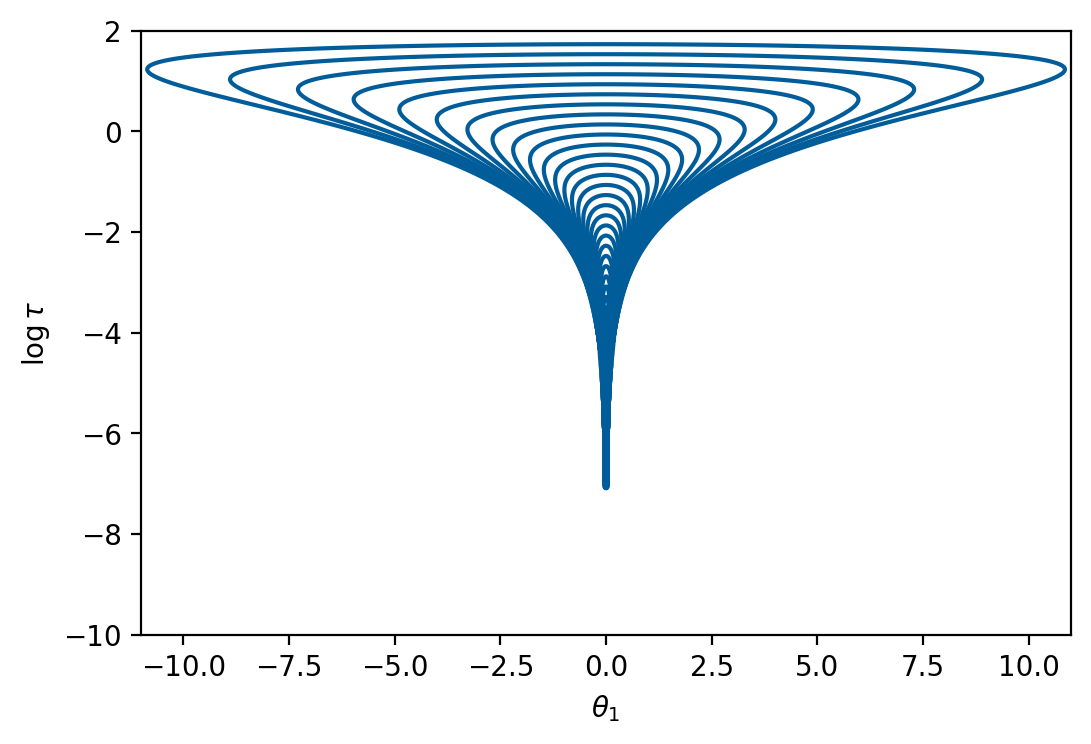

In [181]:
fig,ax = plt.subplots(1,1)
ax.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK)
ax.set_xlabel('$\\theta_1$')
ax.set_ylabel('$\log\\tau$')

In [175]:
np.random.seed(25032021)
n_transitions = 5000
sigma = 0.5
D = 12

mcmc_samples = MH_random_walk(target_lpdf2,D, n_transitions=5000,sigma=sigma)

(-11.0, 11.0)

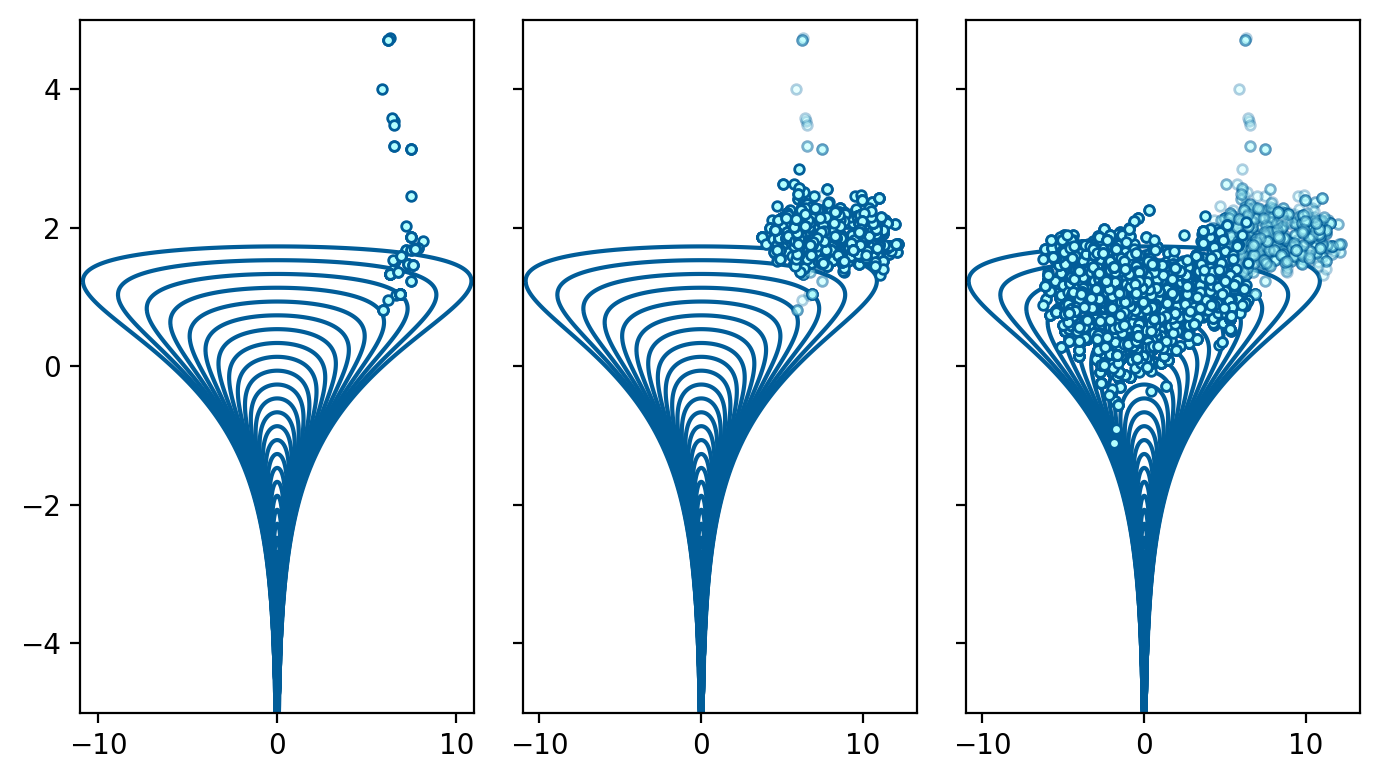

In [176]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = [7,4],tight_layout=True,sharey=True)
ax1.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK,zorder=0)
ax1.scatter(mcmc_samples[:101,2],mcmc_samples[:101,1],ec=DARK,fc=LIGHT,s=12,zorder=1)
ax1.set_ylim(-5,5)
ax1.set_xlim(-11,11)

#ax1.set_aspect('equal')
ax2.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK,zorder=0)
ax2.scatter(mcmc_samples[:101,2],mcmc_samples[:101,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax2.scatter(mcmc_samples[101:1001,2],mcmc_samples[101:1001,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax2.set_ylim(-5,5)
ax1.set_xlim(-11,11)
#ax2.set_aspect('equal')
ax3.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=DARK,zorder=0)
ax3.scatter(mcmc_samples[:1001,2],mcmc_samples[:1001,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax3.scatter(mcmc_samples[1001:,2],mcmc_samples[1001:,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax3.set_ylim(-5,5)
ax1.set_xlim(-11,11)
#ax3.set_aspect('equal')


<AxesSubplot:xlabel='$\\theta_1$', ylabel='$\\log\\tau$'>

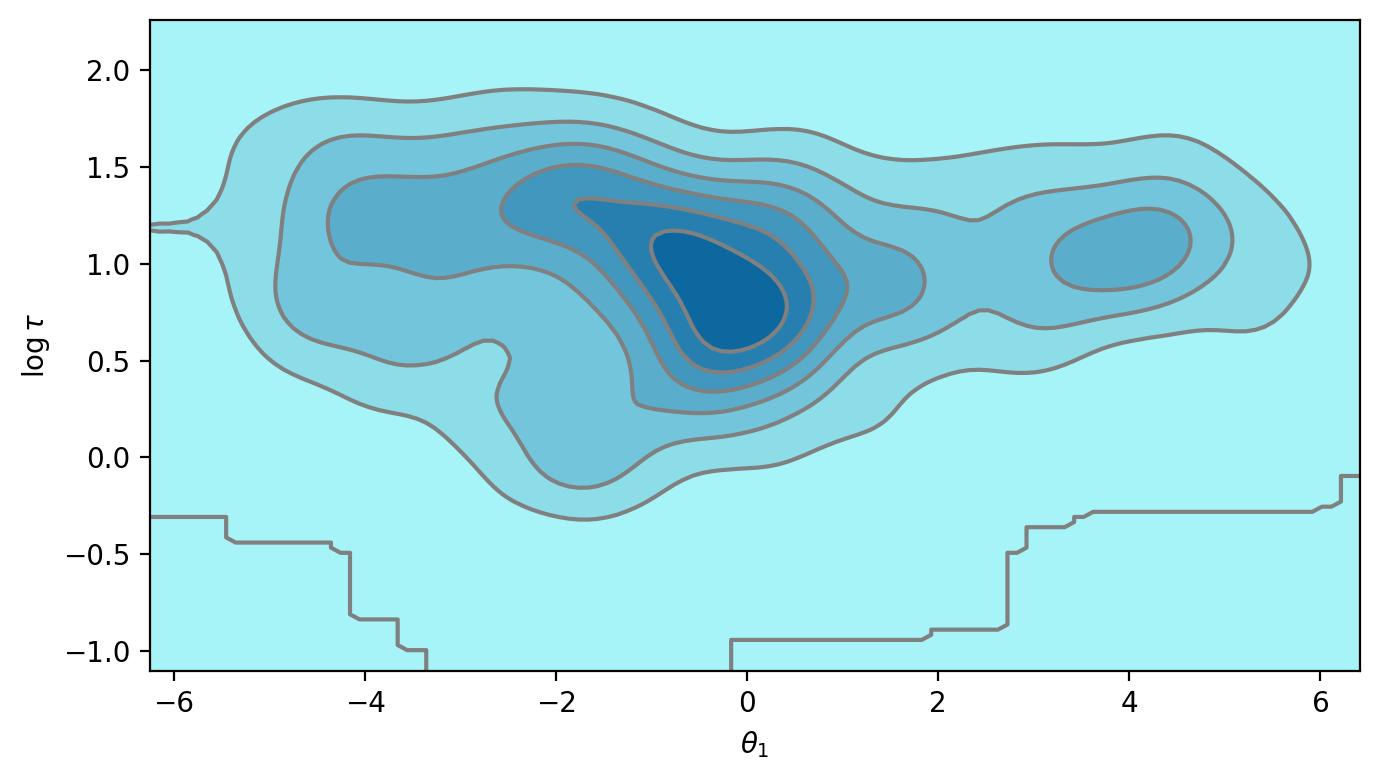

In [182]:
fig,ax =plt.subplots(1,1,figsize=(7,4),tight_layout=True)
ax.set_xlabel('$\\theta_1$')
ax.set_ylabel('$\log\\tau$')
az.plot_dist(mcmc_samples[1001:,2],mcmc_samples[1001:,1],contourf_kwargs={'cmap':my_cmap},ax=ax)

In [83]:
mc_stats(mcmc_samples[:,[0,1,-1]],warmup_iters=100,variable_names=["mu", "log tau"])

mean  standard deviation   mcmc_se    ESS  \
mu                      0.312808            0.817080  0.100772   67.0   
log tau                 1.059258            0.534453  0.316767    3.0   
acceptance probability  0.352628            0.383232  0.015018  434.0   

                        split_Rhat  
mu                        1.054961  
log tau                   1.456163  
acceptance probability    1.012255

In [84]:
mc_series = pd.DataFrame(mcmc_samples[100:,:2],columns=['var_1','var_2'])
N=len(mc_series)
series_mcse = lambda series: az.mcse(series.values)
expan_mean_1 = mc_series.var_1.expanding().mean()
expan_std_1 = mc_series.var_1.expanding().apply(series_mcse)
expan_mean_2 = mc_series.var_2.expanding().mean()
expan_std_2 = mc_series.var_2.expanding().apply(series_mcse)

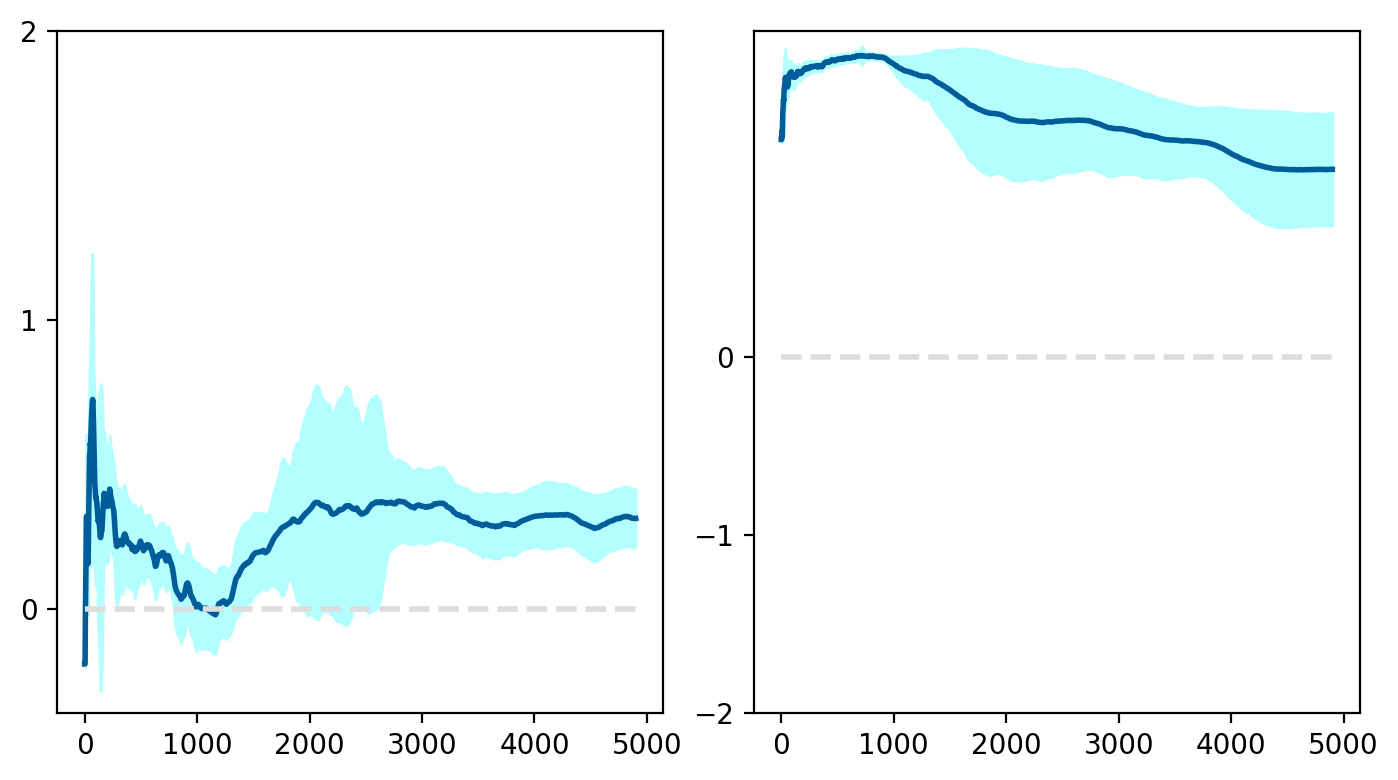

In [85]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(expan_mean_1,color=DARK,linewidth=2)
ax1.plot([0,N],[0,0],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.fill_between([*range(N)],expan_mean_1-expan_std_1,expan_mean_1+expan_std_1,color=LIGHT)

ax2.plot(expan_mean_2,color=DARK,linewidth=2)
ax2.fill_between([*range(N)],expan_mean_2-expan_std_2,expan_mean_2+expan_std_2,color=LIGHT)
ax2.plot([0,N],[0,0],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.set_yticks([0,1,2])
ax2.set_yticks([-2,-1,0])

plt.tight_layout()

In [188]:
np.random.seed(25032021)
n_transitions = int(1e5)
sigma = 0.5
D = 12

mcmc_samples = MH_random_walk(target_lpdf2,D, n_transitions=n_transitions,sigma=sigma)

mc_stats(mcmc_samples,warmup_iters=100)

mean  standard deviation   mcmc_se     ESS  \
var_1                  -0.106792            0.872762  0.144554    37.0   
var_2                   1.118109            0.571156  0.211068     7.0   
var_3                   1.042721            4.179401  1.779564     8.0   
var_4                  -1.647198            3.024926  0.923889    11.0   
var_5                   0.913784            3.426451  0.879613    16.0   
var_6                  -0.810684            3.312639  0.779995    18.0   
var_7                   0.372268            3.681589  2.256704     3.0   
var_8                  -2.383676            3.374558  2.270753     2.0   
var_9                  -0.522316            3.059021  0.877675    12.0   
var_10                  1.236234            4.143016  1.446115    12.0   
var_11                  0.568072            2.965714  0.720928    19.0   
var_12                 -1.066971            3.580158  2.059847     3.0   
acceptance probability  0.357403            0.386035  0.010598  1717.0   

                        split_Rhat  
var_1                     1.042897  
var_2                     1.537073  
var_3                     1.317717  
var_4                     1.258540  
var_5                     1.107085  
var_6                     1.133742  
var_7                     1.379669  
var_8                     1.389788  
var_9                     1.224503  
var_10                    1.395559  
var_11                    1.210537  
var_12                    1.391494  
acceptance probability    1.007714

## Freezing is bad


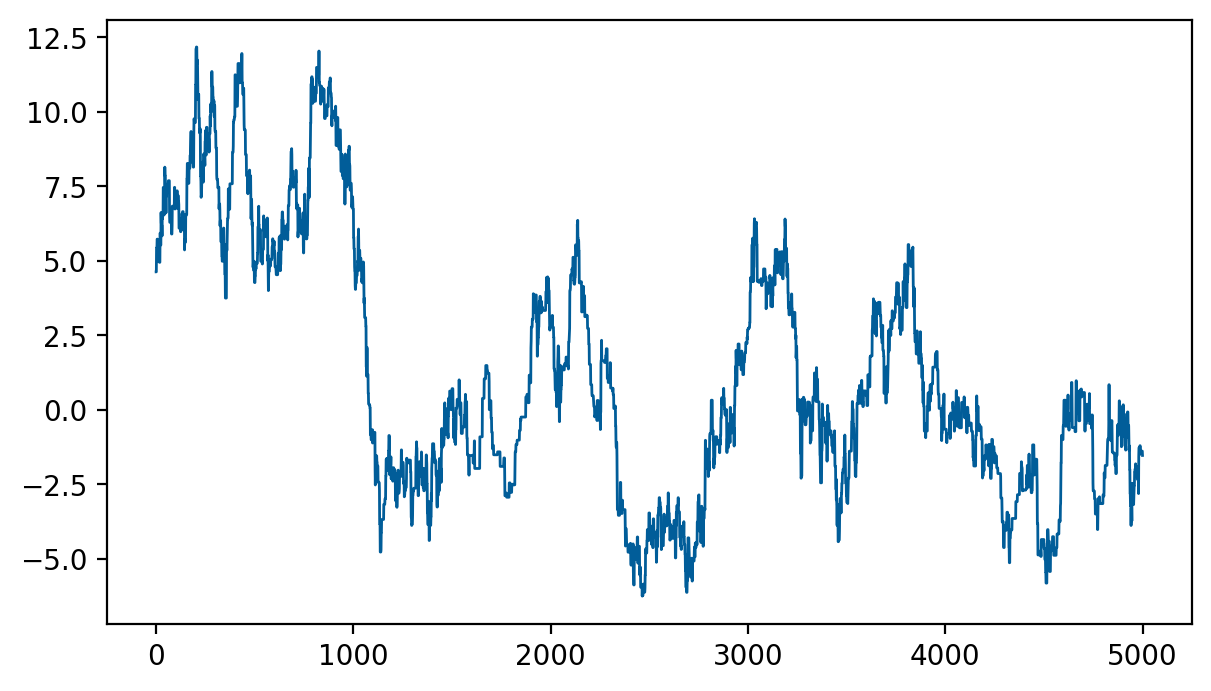

In [184]:
fig, ax1 = plt.subplots(1,1,figsize = (7,4))

ax1.plot(mcmc_samples[:,2],color=DARK,linewidth=1)

## Multiple chains help finding problems


/var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/ipykernel_76505/3079108324.py:13: RuntimeWarning: overflow encountered in exp
  accept_prob = np.min([1., np.exp(target(qp) - target(q0))])


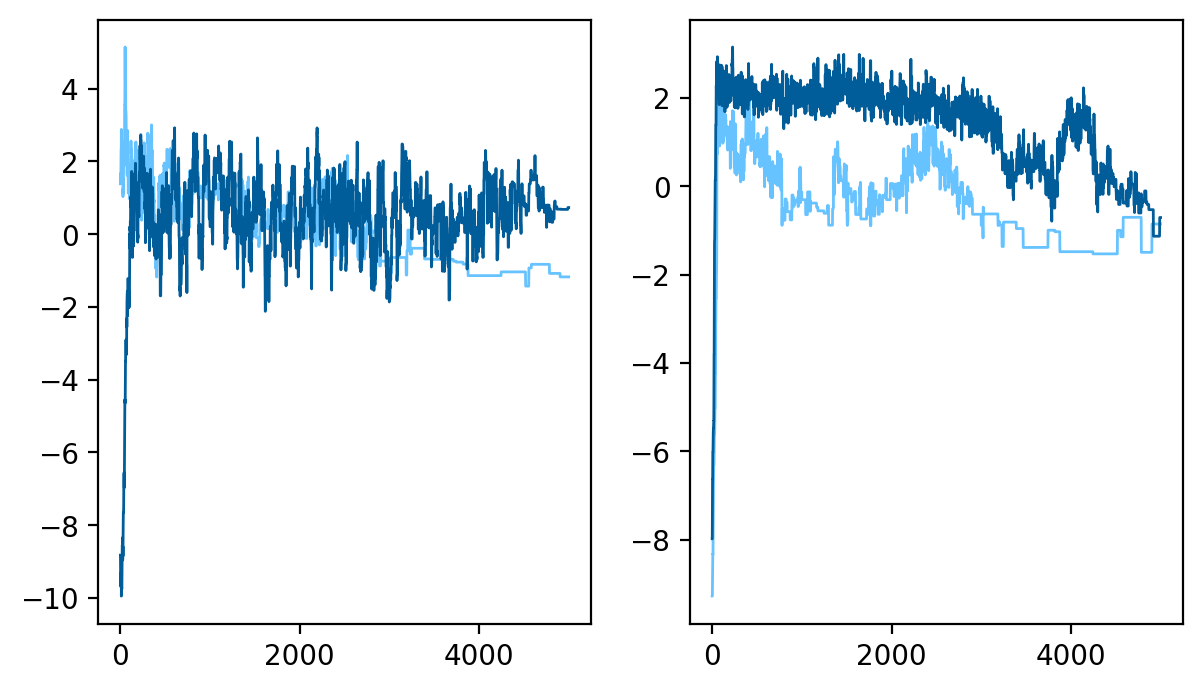

In [186]:
np.random.seed(17)
funnel_chain1 = MH_random_walk(target_lpdf2,D, n_transitions=5000,sigma=sigma)
funnel_chain2 = MH_random_walk(target_lpdf2,D, n_transitions=5000,sigma=sigma)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))
ax1.plot(funnel_chain1[:,0],color=MID,linewidth=1)
ax1.plot(funnel_chain2[:,0],color=DARK,linewidth=1)
ax2.plot(funnel_chain1[:,1],color=MID,linewidth=1)
ax2.plot(funnel_chain2[:,1],color=DARK,linewidth=1)

In [187]:
mcmc_2chain = np.append(funnel_chain1,funnel_chain2[101:],axis=0)
mc_stats(mcmc_2chain,warmup_iters=100,n_chains=2)

mean  standard deviation   mcmc_se   ESS  \
var_1                   0.362855            0.969175  0.344541   9.0   
var_2                   0.472385            1.237601  1.006722   2.0   
var_3                   0.816766            2.706395  0.660590  19.0   
var_4                  -0.050880            2.860394  0.760995  13.0   
var_5                   3.616475            5.347860  3.686223   3.0   
var_6                   0.831729            3.425266  0.858788  15.0   
var_7                   2.271796            5.594822  2.000837  13.0   
var_8                   0.259649            2.745674  0.719737  14.0   
var_9                   0.710636            2.284573  0.441597  25.0   
var_10                  3.044439            5.861226  3.584156   3.0   
var_11                  0.302214            2.719450  0.750531  13.0   
var_12                  1.295288            3.265543  0.900694  20.0   
acceptance probability  0.246732            0.361487  0.152236   4.0   

                        split_Rhat  
var_1                     1.441123  
var_2                     2.259738  
var_3                     1.276428  
var_4                     1.390874  
var_5                     1.968509  
var_6                     1.267782  
var_7                     1.543801  
var_8                     1.550365  
var_9                     1.144704  
var_10                    1.761861  
var_11                    1.414487  
var_12                    1.310937  
acceptance probability    1.246433

## Example - multimodality

$$
q\sim\frac{1}{2}\mathrm{Normal}\left(\begin{bmatrix}4\\8\end{bmatrix},\begin{bmatrix}1&0\\0&2\end{bmatrix}\right)+\frac{1}{2}\mathrm{Normal}\left(\begin{bmatrix}-8\\-4\end{bmatrix},\begin{bmatrix}2&0\\0&1\end{bmatrix}\right)
$$

In [133]:
D = 2

def target_lpdf_c1(q):
  mu1 = 4
  sigma1 = 1

  mu2 = 8
  sigma2 = 2

  lpdf = -0.5 * ( ((q[0] - mu1) / sigma1)**2 + ((q[1] - mu2) / sigma2)**2 )
  lpdf = lpdf - 0.5 * np.log(6.283185307179586) - np.log(sigma1) - np.log(sigma2)
  return lpdf 

def target_lpdf_c2(q):
  mu1 = -8
  sigma1 = 2

  mu2 = -4
  sigma2 = 1

  lpdf = -0.5 * ( ((q[0] - mu1) / sigma1)**2 + ((q[1] - mu2) / sigma2)**2 )
  lpdf = lpdf - 0.5 * np.log(6.283185307179586) - np.log(sigma1) - np.log(sigma2)
  return lpdf



def target_lpdf3(x):
  lpdf1 = np.log(0.5) + target_lpdf_c1(x)
  lpdf2 = np.log(0.5) + target_lpdf_c2(x)
  if lpdf1 > lpdf2:
      lpdf = lpdf1 + np.log(1 + np.exp(lpdf2 - lpdf1))
  else:
      lpdf = lpdf2 + np.log(1 + np.exp(lpdf1 - lpdf2))
  return lpdf


In [190]:
q_1=np.linspace(-13,7,200)
q_2=np.linspace(-7,13,200)
Q1,Q2 = np.meshgrid(q_1,q_2)
Z = np.zeros(Q1.shape)
for i in range(200):
    for j in range(200):
        Z[i,j]=np.exp(target_lpdf3((Q1[i,j],Q2[i,j])))

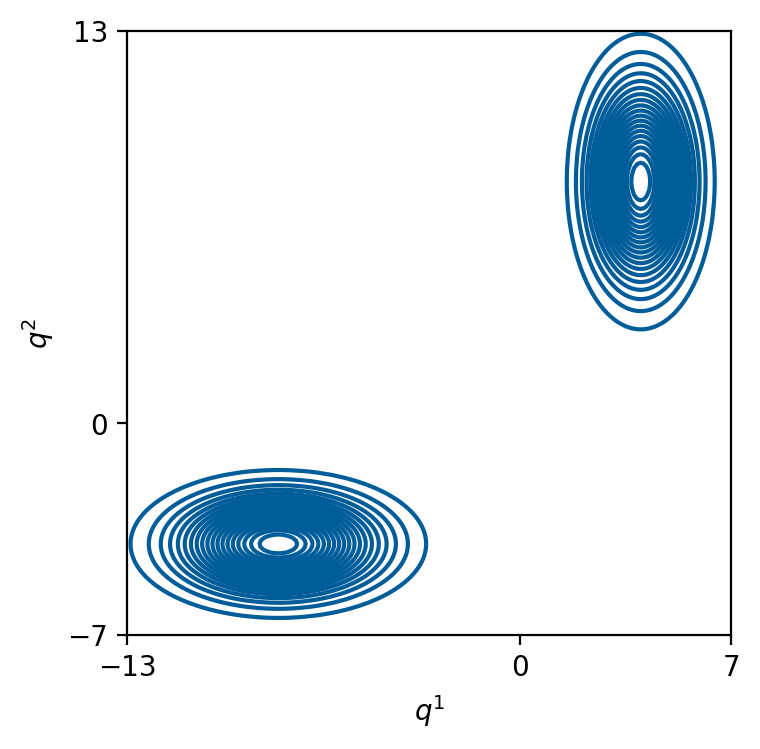

In [193]:
fig,ax = plt.subplots(1,1)
ax.contour(Q1,Q2,Z,levels=20,colors=DARK)
ax.set_aspect('equal')
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$')
ax.set_xlim(-13,7)
ax.set_ylim(-7,13)
ax.set_xticks([-13,0,7])
ax.set_yticks([-7,0,13])

In [194]:
np.random.seed(25032021)
n_transitions = 5000
sigma = 2
D = 2
mcmc_samples = MH_random_walk(target_lpdf3,2)


In [195]:
mc_stats(mcmc_samples[:,[0,1,-1]],warmup_iters=100,variable_names=["q_1", "q_2"])

mean  standard deviation   mcmc_se     ESS  \
q_1                     3.940946            1.006392  0.035944   788.0   
q_2                     7.995697            2.040972  0.106708   377.0   
acceptance probability  0.401185            0.396552  0.005485  5253.0   

                        split_Rhat  
q_1                       1.002237  
q_2                       1.006069  
acceptance probability    0.999711

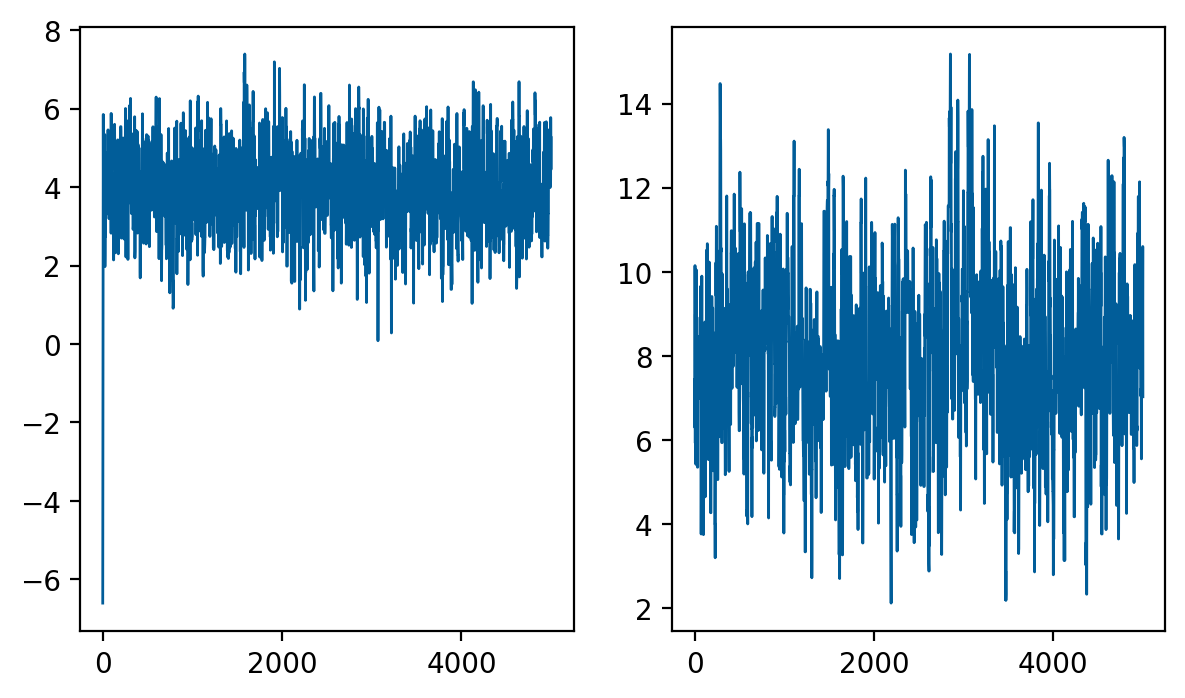

In [214]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))
ax1.plot(mcmc_samples[:,0],color=DARK,linewidth=1)
ax2.plot(mcmc_samples[:,1],color=DARK,linewidth=1)
plt.show()

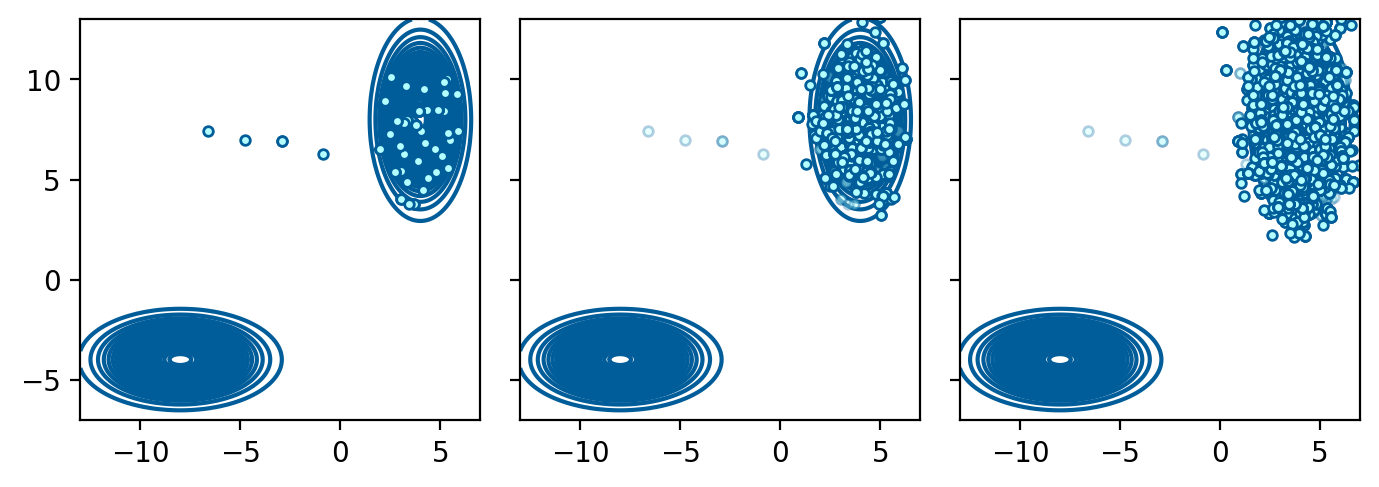

In [197]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = [7,4],tight_layout=True,sharey=True)
ax1.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax1.scatter(mcmc_samples[:101,0],mcmc_samples[:101,1],ec=DARK,fc=LIGHT,s=12,zorder=1)
ax1.set_xlim(-13,7)
ax1.set_ylim(-7,13)

ax1.set_aspect('equal')
ax2.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax2.scatter(mcmc_samples[:101,0],mcmc_samples[:101,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax2.scatter(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax2.set_xlim(-13,7)
ax2.set_ylim(-7,13)
ax2.set_aspect('equal')
ax3.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax3.scatter(mcmc_samples[:1001,0],mcmc_samples[:1001,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax3.scatter(mcmc_samples[1001:,0],mcmc_samples[1001:,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax3.set_xlim(-13,7)
ax3.set_ylim(-7,13)
ax3.set_aspect('equal')

In [215]:
np.random.seed(25032021)
n_transitions = 200000
sigma = 2
D = 2
mcmc_samples = MH_random_walk(target_lpdf3,2,n_transitions = 200000)


In [216]:
mcmc_samples.shape

(200001, 3)

In [217]:
mc_stats(mcmc_samples[:,[0,1,-1]],warmup_iters=100,variable_names=["q_1", "q_2"])

mean  standard deviation   mcmc_se       ESS  \
q_1                    -2.120862            6.186773  6.007144       1.0   
q_2                     1.866986            6.201349  6.023171       1.0   
acceptance probability  0.402297            0.395430  0.000865  205525.0   

                        split_Rhat  
q_1                       1.756584  
q_2                       1.753685  
acceptance probability    1.000006

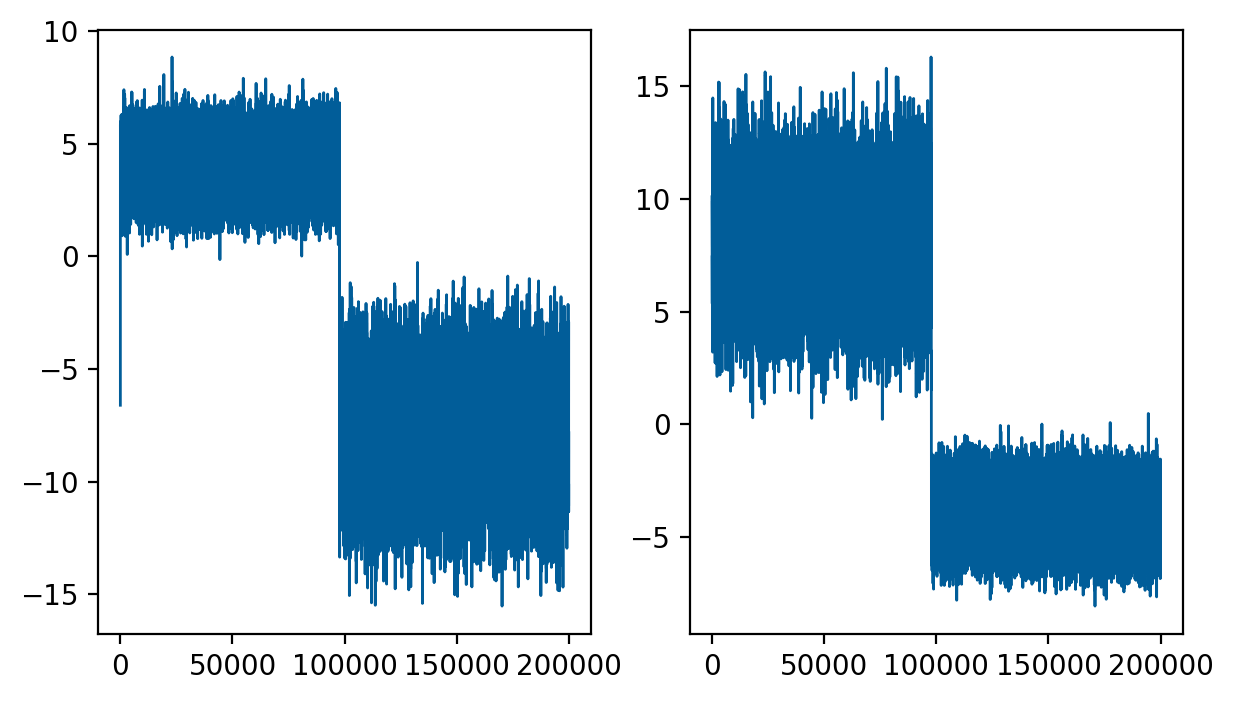

In [218]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(mcmc_samples[:,0],color=DARK,linewidth=1)
ax2.plot(mcmc_samples[:,1],color=DARK,linewidth=1)

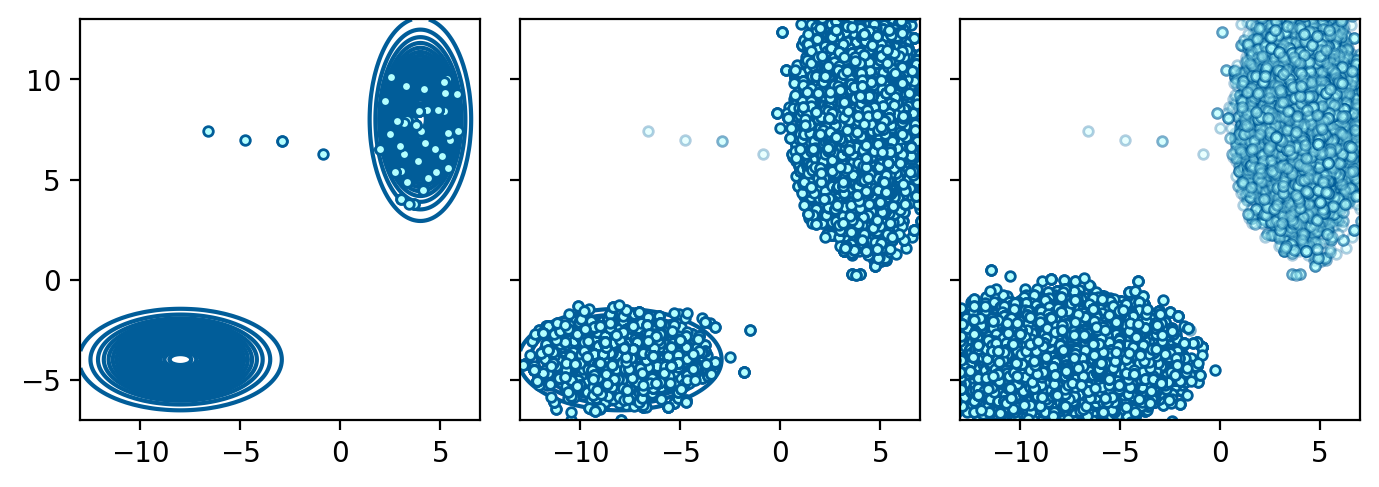

In [220]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = [7,4],tight_layout=True,sharey=True)
ax1.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax1.scatter(mcmc_samples[:101,0],mcmc_samples[:101,1],ec=DARK,fc=LIGHT,s=12,zorder=1)
ax1.set_xlim(-13,7)
ax1.set_ylim(-7,13)

ax1.set_aspect('equal')
ax2.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax2.scatter(mcmc_samples[:101,0],mcmc_samples[:101,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax2.scatter(mcmc_samples[101:100001,0],mcmc_samples[101:100001,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax2.set_xlim(-13,7)
ax2.set_ylim(-7,13)
ax2.set_aspect('equal')
ax3.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax3.scatter(mcmc_samples[:100001,0],mcmc_samples[:100001,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax3.scatter(mcmc_samples[100001:,0],mcmc_samples[100001:,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax3.set_xlim(-13,7)
ax3.set_ylim(-7,13)
ax3.set_aspect('equal')

## Multiple chains can help with detecting multimodality

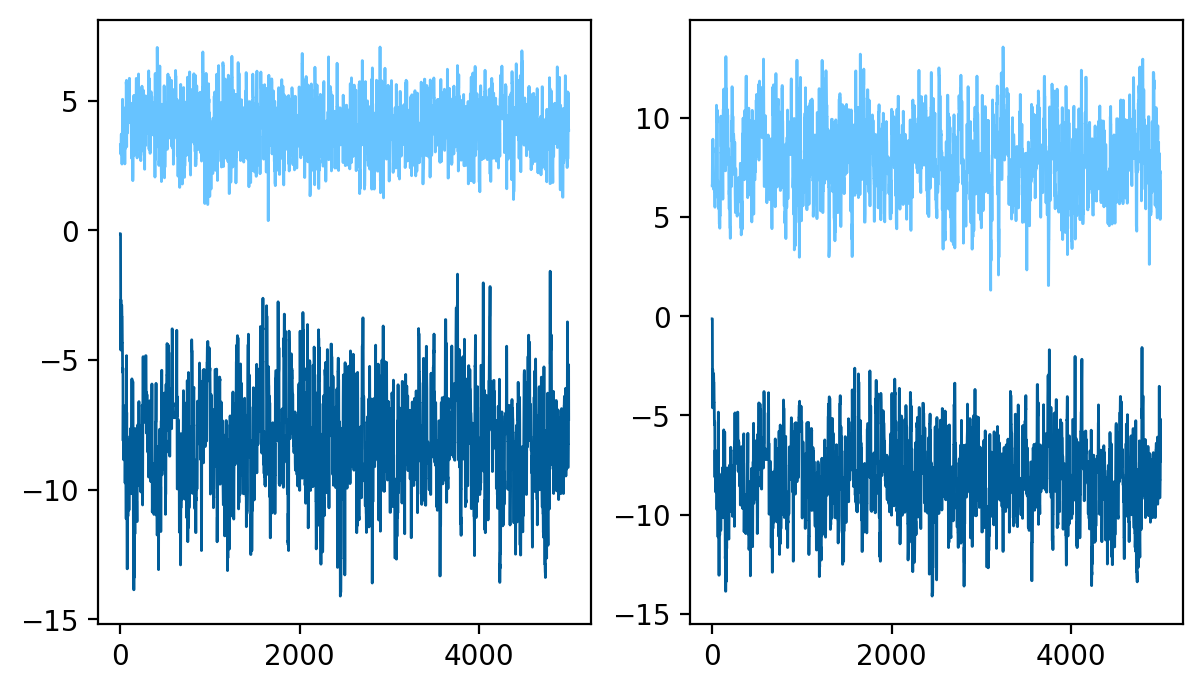

In [152]:
mc_chain1 = MH_random_walk(target_lpdf3,2)
mc_chain2 = MH_random_walk(target_lpdf3,2)


fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(mc_chain1[:,0],color=MID,linewidth=1)
ax1.plot(mc_chain2[:,0],color=DARK,linewidth=1)

ax2.plot(mc_chain1[:,1],color=MID,linewidth=1)
ax2.plot(mc_chain2[:,0],color=DARK,linewidth=1)


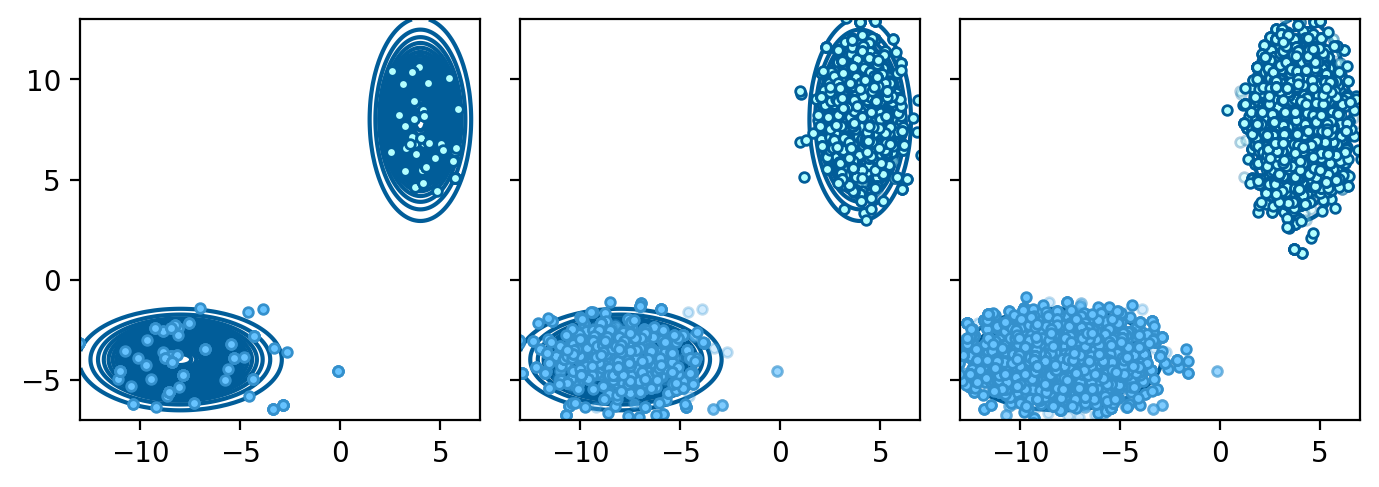

In [153]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = [7,4],tight_layout=True,sharey=True)
ax1.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax1.scatter(mc_chain1[:101,0],mc_chain1[:101,1],ec=DARK,fc=LIGHT,s=12,zorder=1)
ax1.scatter(mc_chain2[:101,0],mc_chain2[:101,1],ec=MID_HIGHLIGHT,fc=MID,s=12,zorder=1)

ax1.set_xlim(-13,7)
ax1.set_ylim(-7,13)

ax1.set_aspect('equal')
ax2.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax2.scatter(mc_chain1[:101,0],mc_chain1[:101,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax2.scatter(mc_chain1[101:1001,0],mc_chain1[101:1001,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax2.scatter(mc_chain2[:101,0],mc_chain2[:101,1],ec=MID_HIGHLIGHT,fc=MID,s=12,alpha=0.3,zorder=1)
ax2.scatter(mc_chain2[101:1001,0],mc_chain2[101:1001,1],ec=MID_HIGHLIGHT,fc=MID,s=12,zorder=2)
ax2.set_xlim(-13,7)
ax2.set_ylim(-7,13)
ax2.set_aspect('equal')
ax3.contour(Q1,Q2,Z,levels=25,colors=DARK,zorder=0)
ax3.scatter(mc_chain1[:1001,0],mc_chain1[:1001,1],ec=DARK,fc=LIGHT,s=12,alpha=0.3,zorder=1)
ax3.scatter(mc_chain1[1001:,0],mc_chain1[1001:,1],ec=DARK,fc=LIGHT,s=12,zorder=2)
ax3.scatter(mc_chain2[:1001,0],mc_chain2[:1001,1],ec=MID_HIGHLIGHT,fc=MID,s=12,alpha=0.3,zorder=1)
ax3.scatter(mc_chain2[1001:,0],mc_chain2[1001:,1],ec=MID_HIGHLIGHT,fc=MID,s=12,zorder=2)
ax3.set_xlim(-13,7)
ax3.set_ylim(-7,13)
ax3.set_aspect('equal')

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Variational approximation

- The main idea is to approximate the posterior with functions, that can be easily sampled from (or their combination). 

- Such approximation is realized by minimization of a function called divergence, which measures how differetnt candidate and probability distribution are from one another.

- In practice it is done by minimizing certain bound on the divergence.

## Multimodality of variational approximation

It can happen, that significantly different candidates have similar divergences, that causes optimization problem to be multimodal



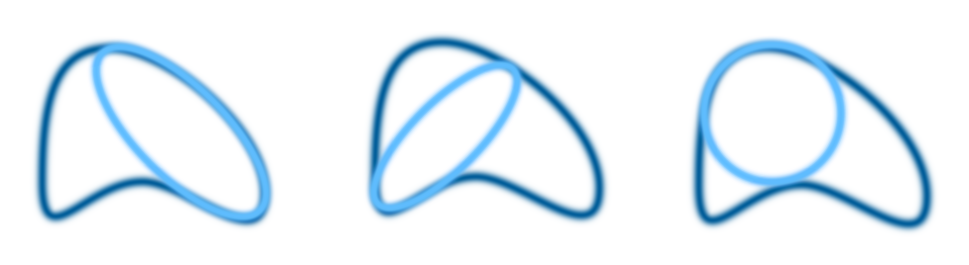

In [102]:
fig,ax = plt.subplots(1,3)
for k in range(3):
    input_file = 'typical_set_with_bad_elipse_{}.pdf'.format(k+1)
    pic_grid = convert_from_path('../tikz/'+input_file,dpi=300,use_pdftocairo=True) 
    output_folder='../markdown/img/'
    output_file=input_file.replace('.pdf','.png')
    pic_grid[0].save(output_folder+output_file, 'PNG')
    ax[k].imshow(pic_grid[0])
    ax[k].set_axis_off()
plt.show()

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>
